In [1]:
import pandas as pd
import numpy as np
from sklearn.metrics import mean_squared_error
# Dynamic path setup
import sys
from pathlib import Path

# Find project root dynamically
current_dir = Path.cwd()
while current_dir.name != "ENEXIS" and current_dir.parent != current_dir:
    current_dir = current_dir.parent
project_root = current_dir

# Add utils to path
utils_path = project_root / "src" / "utils"
sys.path.append(str(utils_path))
from build_training_set import build_training_set
 
df = build_training_set(
    train_start="2025-01-01 00:00:00",
    train_end="2025-03-14 23:00:00",
    run_date="2025-03-15 00:00:00"
)

print(df.tail())
df.to_csv("training_set1.csv", index=False)


        Price           target_datetime      Load  shortwave_radiation  \
1916  0.06842 2025-03-21 20:00:00+00:00  15700.25                  0.0   
1917  0.04569 2025-03-21 21:00:00+00:00  14870.50                  0.0   
1918  0.02923 2025-03-21 22:00:00+00:00  14056.25                  0.0   
1919  0.02108 2025-03-21 23:00:00+00:00  13248.25                  0.0   
1920  0.02693 2025-03-22 00:00:00+00:00  12561.25                  0.0   

      temperature_2m  direct_normal_irradiance  diffuse_radiation  Flow_NO  \
1916           13.05                       0.0                0.0    621.0   
1917           13.00                       0.0                0.0    620.0   
1918           12.60                       0.0                0.0    621.0   
1919           12.00                       0.0                0.0    621.0   
1920           10.05                       0.0                0.0    621.0   

      yearday_cos  Flow_GB  ...  is_dst  yearday_sin  wind_speed_10m  \
1916     0.193

In [2]:
from sklearn.ensemble import RandomForestRegressor

df['target_datetime'] = pd.to_datetime(df['target_datetime'], utc=True)
df['Timestamp'] = df['target_datetime']
# Feature engineering
df = df.dropna(subset=['target_datetime', 'Price'])

# Stel de periodes in
train_start = pd.Timestamp('2025-01-01', tz = 'UTC')
train_end = pd.Timestamp('2025-03-14 23:59:59', tz = 'UTC')
test_start = pd.Timestamp('2025-03-15', tz = 'UTC')
test_end = pd.Timestamp('2025-06-04 23:59:59', tz = 'UTC')

# Filter op basis van Timestamp
train = df[(df['Timestamp'] >= train_start) & (df['Timestamp'] <= train_end)]
test = df[(df['Timestamp'] >= test_start) & (df['Timestamp'] <= test_end)]

X_train = train[['weekday_sin', 'weekday_cos', 'hour_sin', 'hour_cos']]	
y_train = train['Price']
X_test = test[['weekday_sin', 'weekday_cos', 'hour_sin', 'hour_cos']]	
y_test = test['Price']

# Model
model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

# Evaluatie
from sklearn.metrics import mean_absolute_error
print("MAE:", mean_absolute_error(y_test, y_pred))

from sklearn.metrics import mean_squared_error
import numpy as np

mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))

print("MAE:", mae)
print("RMSE:", rmse)

MAE: 0.03909749904648032
MAE: 0.03909749904648032
RMSE: 0.052045362881131936


In [6]:
from sklearn.ensemble import RandomForestRegressor

df['target_datetime'] = pd.to_datetime(df['target_datetime'], utc=True)
df['Timestamp'] = df['target_datetime']
# Feature engineering
df = df.dropna(subset=['target_datetime', 'Price'])

# Stel de periodes in
train_start = pd.Timestamp('2025-01-01', tz = 'UTC')
train_end = pd.Timestamp('2025-03-14 23:59:59', tz = 'UTC')
test_start = pd.Timestamp('2025-03-15', tz = 'UTC')
test_end = pd.Timestamp('2025-03-21 23:59:59', tz = 'UTC')

# Filter op basis van Timestamp
train = df[(df['Timestamp'] >= train_start) & (df['Timestamp'] <= train_end)]
test = df[(df['Timestamp'] >= test_start) & (df['Timestamp'] <= test_end)]

# Features voor het model
features = [
    'Flow_NO',  'hour_sin', 
    'Load','shortwave_radiation', 'temperature_2m', 
    'Flow_GB', 'weekday_sin'
] # excluded: 'month', 'yearday_sin', 'weekday_cos', diffuse_radiation', 'yearday_cos', 'hour_cos','is_dst','is_non_working_day', 'is_weekend','cloud_cover','direct_normal_irradiance',


X_train = train[features]
y_train = train['Price']
X_test = test[features]
y_test = test['Price']

# Model
model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

# Evaluatie
from sklearn.metrics import mean_absolute_error
print("MAE:", mean_absolute_error(y_test, y_pred))

from sklearn.metrics import mean_squared_error
import numpy as np

mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))

print("MAE:", mae)
print("RMSE:", rmse)

MAE: 0.026108877976190478
MAE: 0.026108877976190478
RMSE: 0.03805234969059151


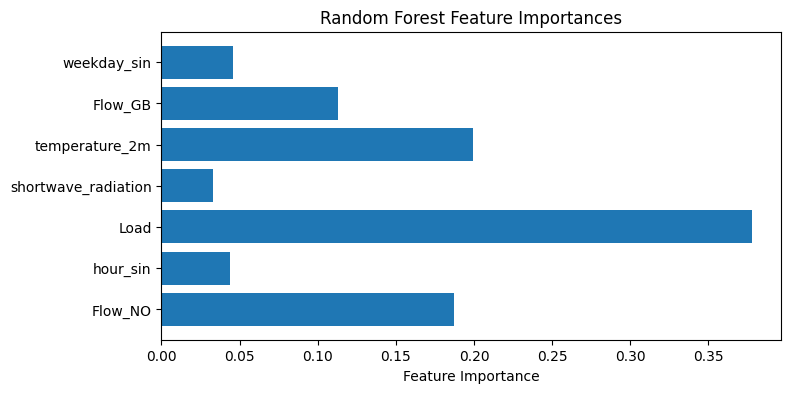

In [7]:
import matplotlib.pyplot as plt

importances = model.feature_importances_
feature_names = X_train.columns

plt.figure(figsize=(8, 4))
plt.barh(feature_names, importances)
plt.xlabel("Feature Importance")
plt.title("Random Forest Feature Importances")
plt.show()

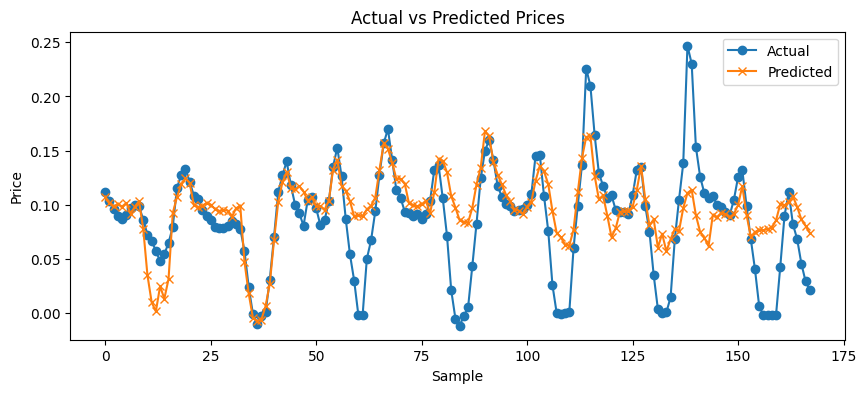

In [8]:
plt.figure(figsize=(10, 4))
plt.plot(y_test.values, label='Actual', marker='o')
plt.plot(y_pred, label='Predicted', marker='x')
plt.legend()
plt.title("Actual vs Predicted Prices")
plt.xlabel("Sample")
plt.ylabel("Price")
plt.show()

In [2]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
import sys
from pathlib import Path

# Zorg dat build_training_set geïmporteerd is
current_dir = Path.cwd()
while current_dir.name != "ENEXIS" and current_dir.parent != current_dir:
    current_dir = current_dir.parent
project_root = current_dir
utils_path = project_root / "src" / "utils"
sys.path.append(str(utils_path))
from build_training_set import build_training_set

# Define feature columns and target
FEATURES = ['weekday_cos', 'weekday_sin', 'hour_cos', 'hour_sin', 'yearday_cos', 'yearday_sin']
TRAIN_FEATURES = FEATURES
target = 'Price'

# Initial training window
base_start = "2025-01-01 00:00:00"
base_end = "2025-03-14 23:00:00"
base_run = "2025-03-15 00:00:00"

rmse_results = []

print("🔍 Testing Random Forest Model - RMSE per forecast day")
print("=" * 60)

for i in range(30):
    start = pd.Timestamp(base_start) + pd.Timedelta(days=i)
    end = pd.Timestamp(base_end) + pd.Timedelta(days=i)
    run_date = pd.Timestamp(base_run) + pd.Timedelta(days=i)

    try:
        df = build_training_set(
            train_start=start.strftime("%Y-%m-%d %H:%M:%S"),
            train_end=end.strftime("%Y-%m-%d %H:%M:%S"),
            run_date=run_date.strftime("%Y-%m-%d %H:%M:%S")
        )

        if df is None or df.empty:
            print(f"Day {i+1}: ❌ No training data returned")
            continue

        df['target_datetime'] = pd.to_datetime(df['target_datetime'], utc=True)
        df = df.sort_values('target_datetime').set_index('target_datetime')

        run_date_utc = run_date.tz_localize("UTC")

        # Split into training and testing sets
        train_data = df[df.index <= run_date_utc]
        test_data = df[df.index > run_date_utc]

        # Drop any missing data in training
        train_data = train_data.dropna(subset=TRAIN_FEATURES + [target])

        if test_data.empty or train_data.empty:
            print(f"Day {i+1}: ❌ Not enough data for training or testing")
            continue

        # Train model
        X_train = train_data[TRAIN_FEATURES]
        y_train = train_data[target]
        model = RandomForestRegressor(n_estimators=100, random_state=42)
        model.fit(X_train, y_train)

        # Zorg dat alle features aanwezig zijn in test_data
        for col in TRAIN_FEATURES:
            if col not in test_data.columns:
                test_data[col] = np.nan

        X_test = test_data[TRAIN_FEATURES]
        y_test = test_data[target]

        # Sla de eerste 24 uur over
        X_test = X_test.iloc[24:]
        y_test = y_test.iloc[24:]

        # Alleen voorspellen als er nog testdata over is
        if len(X_test) > 0:
            y_pred = model.predict(X_test)
            rmse = np.sqrt(mean_squared_error(y_test, y_pred))
        else:
            print("Niet genoeg testdata na lag van 24 uur.")
            rmse = np.nan

        rmse_results.append({
            'iteration': i + 1,
            'run_date': run_date.strftime('%Y-%m-%d'),
            'valid_predictions': len(X_test),
            'rmse': rmse
        })

        print(f"Day {i+1}: ✅ {len(X_test)} test rows, Run: {run_date.strftime('%m-%d')}")

    except Exception as e:
        print(f"Day {i+1}: ❌ Error: {e}")

# Create results dataframe
if rmse_results:
    rmse_df = pd.DataFrame(rmse_results)

    print(f"\n📊 OVERALL RMSE - Random Forest Model")
    print("=" * 80)
    print(f"Successful runs: {rmse_df['rmse'].notna().sum()}/30")

    print(rmse_df[['iteration', 'run_date', 'valid_predictions', 'rmse']].round(2).to_string(index=False))

    print(f"\n📈 SUMMARY STATISTICS")
    print("-" * 40)
    print(rmse_df['rmse'].describe().round(2))

    print(f"\n📊 AVERAGE OVERALL RMSE")
    print("-" * 40)
    print(f"Mean RMSE: {rmse_df['rmse'].mean():.4f}")
    print(f"Stddev RMSE: {rmse_df['rmse'].std():.4f}")

else:
    print("❌ No runs completed successfully")

2025-05-31 10:51:48,635 - build_training_set - INFO - 📅 Loading additional historical data until 2025-03-15 00:00:00+00:00 for lagging support
2025-05-31 10:51:48,635 - build_training_set - INFO - 🚀 Start build van trainingset
2025-05-31 10:51:48,635 - build_training_set - INFO - 🧠 Actuals van 2025-01-01 00:00:00+00:00 t/m 2025-03-14 23:00:00+00:00 (extended to 2025-03-15 00:00:00+00:00 for lagging)
2025-05-31 10:51:48,635 - build_training_set - INFO - 📅 Forecast van run_date 2025-03-15 00:00:00+00:00, normalized to 2025-03-15 00:00:00+00:00 for DB lookup, target range: 2025-03-15 00:00:00+00:00 → 2025-03-22 00:00:00+00:00
2025-05-31 10:51:48,643 - build_training_set - INFO - 📥 Loading actuals with selected columns only...
2025-05-31 10:51:48,644 - build_training_set - INFO - 📋 Requested columns found: 21/21
2025-05-31 10:51:48,644 - build_training_set - INFO - 📋 Using columns: ['Price', 'target_datetime', 'Load', 'shortwave_radiation', 'temperature_2m', 'direct_normal_irradiance', 'di

2025-05-31 10:51:48,702 - build_training_set - INFO - ✅ Actuals loaded: 1752 rows with 21 selected columns
2025-05-31 10:51:48,710 - build_training_set - INFO - 🔍 Loading forecast/prediction data...
2025-05-31 10:51:48,735 - build_training_set - INFO - 📊 Forecast rows available: 169
2025-05-31 10:51:48,760 - build_training_set - INFO - 📋 Common columns for predictions: 17 - ['target_datetime', 'shortwave_radiation', 'temperature_2m', 'direct_normal_irradiance', 'diffuse_radiation', 'yearday_cos', 'month', 'is_dst', 'yearday_sin', 'wind_speed_10m', 'is_non_working_day', 'hour_cos', 'is_weekend', 'cloud_cover', 'weekday_sin', 'hour_sin', 'weekday_cos']
2025-05-31 10:51:48,792 - build_training_set - INFO - ✅ Predictions loaded: 169 rows with 17 columns
2025-05-31 10:51:48,792 - build_training_set - INFO - 🔧 Missing columns in predictions: ['Price', 'Load', 'Flow_NO', 'Flow_GB']
2025-05-31 10:51:48,792 - build_training_set - INFO - 📊 Applying 168-hour lag for missing columns (excluding tar

🔍 Testing Random Forest Model - RMSE per forecast day


2025-05-31 10:51:48,891 - build_training_set - INFO -    ✅ Added Load: 169/169 values found
2025-05-31 10:51:48,901 - build_training_set - INFO -    🕐 Lagging column 'Flow_NO' by 168 hours
2025-05-31 10:51:48,960 - build_training_set - INFO -    ✅ Added Flow_NO: 169/169 values found
2025-05-31 10:51:48,963 - build_training_set - INFO -    🕐 Lagging column 'Flow_GB' by 168 hours
2025-05-31 10:51:49,083 - build_training_set - INFO -    ✅ Added Flow_GB: 169/169 values found
2025-05-31 10:51:49,085 - build_training_set - INFO - 🔄 Combining actuals and predictions...
2025-05-31 10:51:49,085 - build_training_set - INFO - 💰 Retrieving actual prices for forecast period...
2025-05-31 10:51:49,101 - build_training_set - INFO - 📊 Found 169 actual prices for forecast period
2025-05-31 10:51:49,170 - build_training_set - INFO - ✅ Filled 169/169 prediction prices with actual values
2025-05-31 10:51:49,170 - build_training_set - INFO - 💰 Price coverage: 169/169 (100.0%)
2025-05-31 10:51:49,178 - buil

Day 1: ✅ 144 test rows, Run: 03-15


2025-05-31 10:51:50,090 - build_training_set - INFO -    ✅ Added Load: 169/169 values found
2025-05-31 10:51:50,090 - build_training_set - INFO -    🕐 Lagging column 'Flow_NO' by 168 hours
2025-05-31 10:51:50,235 - build_training_set - INFO -    ✅ Added Flow_NO: 169/169 values found
2025-05-31 10:51:50,243 - build_training_set - INFO -    🕐 Lagging column 'Flow_GB' by 168 hours
2025-05-31 10:51:50,372 - build_training_set - INFO -    ✅ Added Flow_GB: 169/169 values found
2025-05-31 10:51:50,372 - build_training_set - INFO - 🔄 Combining actuals and predictions...
2025-05-31 10:51:50,372 - build_training_set - INFO - 💰 Retrieving actual prices for forecast period...
2025-05-31 10:51:50,388 - build_training_set - INFO - 📊 Found 169 actual prices for forecast period
2025-05-31 10:51:50,479 - build_training_set - INFO - ✅ Filled 169/169 prediction prices with actual values
2025-05-31 10:51:50,482 - build_training_set - INFO - 💰 Price coverage: 169/169 (100.0%)
2025-05-31 10:51:50,490 - buil

Day 2: ✅ 144 test rows, Run: 03-16


2025-05-31 10:51:51,635 - build_training_set - INFO -    ✅ Added Load: 169/169 values found
2025-05-31 10:51:51,635 - build_training_set - INFO -    🕐 Lagging column 'Flow_NO' by 168 hours
2025-05-31 10:51:51,736 - build_training_set - INFO -    ✅ Added Flow_NO: 169/169 values found
2025-05-31 10:51:51,736 - build_training_set - INFO -    🕐 Lagging column 'Flow_GB' by 168 hours
2025-05-31 10:51:51,795 - build_training_set - INFO -    ✅ Added Flow_GB: 169/169 values found
2025-05-31 10:51:51,795 - build_training_set - INFO - 🔄 Combining actuals and predictions...
2025-05-31 10:51:51,801 - build_training_set - INFO - 💰 Retrieving actual prices for forecast period...
2025-05-31 10:51:51,801 - build_training_set - INFO - 📊 Found 169 actual prices for forecast period
2025-05-31 10:51:51,855 - build_training_set - INFO - ✅ Filled 169/169 prediction prices with actual values
2025-05-31 10:51:51,857 - build_training_set - INFO - 💰 Price coverage: 169/169 (100.0%)
2025-05-31 10:51:51,857 - buil

Day 3: ✅ 144 test rows, Run: 03-17


2025-05-31 10:51:52,796 - build_training_set - INFO -    ✅ Added Load: 169/169 values found
2025-05-31 10:51:52,796 - build_training_set - INFO -    🕐 Lagging column 'Flow_NO' by 168 hours
2025-05-31 10:51:52,901 - build_training_set - INFO -    ✅ Added Flow_NO: 169/169 values found
2025-05-31 10:51:52,901 - build_training_set - INFO -    🕐 Lagging column 'Flow_GB' by 168 hours
2025-05-31 10:51:52,984 - build_training_set - INFO -    ✅ Added Flow_GB: 169/169 values found
2025-05-31 10:51:52,984 - build_training_set - INFO - 🔄 Combining actuals and predictions...
2025-05-31 10:51:52,984 - build_training_set - INFO - 💰 Retrieving actual prices for forecast period...
2025-05-31 10:51:52,984 - build_training_set - INFO - 📊 Found 169 actual prices for forecast period
2025-05-31 10:51:53,041 - build_training_set - INFO - ✅ Filled 169/169 prediction prices with actual values
2025-05-31 10:51:53,041 - build_training_set - INFO - 💰 Price coverage: 169/169 (100.0%)
2025-05-31 10:51:53,050 - buil

Day 4: ✅ 144 test rows, Run: 03-18


2025-05-31 10:51:54,024 - build_training_set - INFO -    🕐 Lagging column 'Flow_NO' by 168 hours
2025-05-31 10:51:54,125 - build_training_set - INFO -    ✅ Added Flow_NO: 169/169 values found
2025-05-31 10:51:54,125 - build_training_set - INFO -    🕐 Lagging column 'Flow_GB' by 168 hours
2025-05-31 10:51:54,209 - build_training_set - INFO -    ✅ Added Flow_GB: 169/169 values found
2025-05-31 10:51:54,209 - build_training_set - INFO - 🔄 Combining actuals and predictions...
2025-05-31 10:51:54,209 - build_training_set - INFO - 💰 Retrieving actual prices for forecast period...
2025-05-31 10:51:54,209 - build_training_set - INFO - 📊 Found 169 actual prices for forecast period
2025-05-31 10:51:54,272 - build_training_set - INFO - ✅ Filled 169/169 prediction prices with actual values
2025-05-31 10:51:54,274 - build_training_set - INFO - 💰 Price coverage: 169/169 (100.0%)
2025-05-31 10:51:54,278 - build_training_set - INFO - ✅ Combined dataset: 1921 rows (1752 actuals + 169 predictions)
2025-

Day 5: ✅ 144 test rows, Run: 03-19


2025-05-31 10:51:55,263 - build_training_set - INFO -    ✅ Added Load: 169/169 values found
2025-05-31 10:51:55,267 - build_training_set - INFO -    🕐 Lagging column 'Flow_NO' by 168 hours
2025-05-31 10:51:55,373 - build_training_set - INFO -    ✅ Added Flow_NO: 169/169 values found
2025-05-31 10:51:55,373 - build_training_set - INFO -    🕐 Lagging column 'Flow_GB' by 168 hours
2025-05-31 10:51:55,527 - build_training_set - INFO -    ✅ Added Flow_GB: 169/169 values found
2025-05-31 10:51:55,527 - build_training_set - INFO - 🔄 Combining actuals and predictions...
2025-05-31 10:51:55,527 - build_training_set - INFO - 💰 Retrieving actual prices for forecast period...
2025-05-31 10:51:55,534 - build_training_set - INFO - 📊 Found 169 actual prices for forecast period
2025-05-31 10:51:55,606 - build_training_set - INFO - ✅ Filled 169/169 prediction prices with actual values
2025-05-31 10:51:55,612 - build_training_set - INFO - 💰 Price coverage: 169/169 (100.0%)
2025-05-31 10:51:55,617 - buil

Day 6: ✅ 144 test rows, Run: 03-20


2025-05-31 10:51:56,689 - build_training_set - INFO -    ✅ Added Load: 169/169 values found
2025-05-31 10:51:56,689 - build_training_set - INFO -    🕐 Lagging column 'Flow_NO' by 168 hours
2025-05-31 10:51:56,822 - build_training_set - INFO -    ✅ Added Flow_NO: 169/169 values found
2025-05-31 10:51:56,822 - build_training_set - INFO -    🕐 Lagging column 'Flow_GB' by 168 hours
2025-05-31 10:51:56,917 - build_training_set - INFO -    ✅ Added Flow_GB: 169/169 values found
2025-05-31 10:51:56,934 - build_training_set - INFO - 🔄 Combining actuals and predictions...
2025-05-31 10:51:56,935 - build_training_set - INFO - 💰 Retrieving actual prices for forecast period...
2025-05-31 10:51:56,935 - build_training_set - INFO - 📊 Found 169 actual prices for forecast period
2025-05-31 10:51:56,970 - build_training_set - INFO - ✅ Filled 169/169 prediction prices with actual values
2025-05-31 10:51:56,984 - build_training_set - INFO - 💰 Price coverage: 169/169 (100.0%)
2025-05-31 10:51:56,984 - buil

Day 7: ✅ 144 test rows, Run: 03-21


2025-05-31 10:51:57,907 - build_training_set - INFO -    ✅ Added Load: 169/169 values found
2025-05-31 10:51:57,907 - build_training_set - INFO -    🕐 Lagging column 'Flow_NO' by 168 hours
2025-05-31 10:51:58,031 - build_training_set - INFO -    ✅ Added Flow_NO: 169/169 values found
2025-05-31 10:51:58,033 - build_training_set - INFO -    🕐 Lagging column 'Flow_GB' by 168 hours
2025-05-31 10:51:58,150 - build_training_set - INFO -    ✅ Added Flow_GB: 169/169 values found
2025-05-31 10:51:58,150 - build_training_set - INFO - 🔄 Combining actuals and predictions...
2025-05-31 10:51:58,166 - build_training_set - INFO - 💰 Retrieving actual prices for forecast period...
2025-05-31 10:51:58,169 - build_training_set - INFO - 📊 Found 169 actual prices for forecast period
2025-05-31 10:51:58,223 - build_training_set - INFO - ✅ Filled 169/169 prediction prices with actual values
2025-05-31 10:51:58,223 - build_training_set - INFO - 💰 Price coverage: 169/169 (100.0%)
2025-05-31 10:51:58,233 - buil

Day 8: ✅ 144 test rows, Run: 03-22


2025-05-31 10:51:59,083 - build_training_set - INFO -    🕐 Lagging column 'Flow_NO' by 168 hours
2025-05-31 10:51:59,161 - build_training_set - INFO -    ✅ Added Flow_NO: 169/169 values found
2025-05-31 10:51:59,161 - build_training_set - INFO -    🕐 Lagging column 'Flow_GB' by 168 hours
2025-05-31 10:51:59,228 - build_training_set - INFO -    ✅ Added Flow_GB: 169/169 values found
2025-05-31 10:51:59,228 - build_training_set - INFO - 🔄 Combining actuals and predictions...
2025-05-31 10:51:59,228 - build_training_set - INFO - 💰 Retrieving actual prices for forecast period...
2025-05-31 10:51:59,235 - build_training_set - INFO - 📊 Found 169 actual prices for forecast period
2025-05-31 10:51:59,285 - build_training_set - INFO - ✅ Filled 169/169 prediction prices with actual values
2025-05-31 10:51:59,285 - build_training_set - INFO - 💰 Price coverage: 169/169 (100.0%)
2025-05-31 10:51:59,285 - build_training_set - INFO - ✅ Combined dataset: 1921 rows (1752 actuals + 169 predictions)
2025-

Day 9: ✅ 144 test rows, Run: 03-23


2025-05-31 10:52:00,289 - build_training_set - INFO -    ✅ Added Load: 169/169 values found
2025-05-31 10:52:00,295 - build_training_set - INFO -    🕐 Lagging column 'Flow_NO' by 168 hours
2025-05-31 10:52:00,411 - build_training_set - INFO -    ✅ Added Flow_NO: 169/169 values found
2025-05-31 10:52:00,413 - build_training_set - INFO -    🕐 Lagging column 'Flow_GB' by 168 hours
2025-05-31 10:52:00,499 - build_training_set - INFO -    ✅ Added Flow_GB: 169/169 values found
2025-05-31 10:52:00,505 - build_training_set - INFO - 🔄 Combining actuals and predictions...
2025-05-31 10:52:00,505 - build_training_set - INFO - 💰 Retrieving actual prices for forecast period...
2025-05-31 10:52:00,517 - build_training_set - INFO - 📊 Found 169 actual prices for forecast period
2025-05-31 10:52:00,588 - build_training_set - INFO - ✅ Filled 169/169 prediction prices with actual values
2025-05-31 10:52:00,599 - build_training_set - INFO - 💰 Price coverage: 169/169 (100.0%)
2025-05-31 10:52:00,599 - buil

Day 10: ✅ 144 test rows, Run: 03-24


2025-05-31 10:52:01,682 - build_training_set - INFO -    ✅ Added Load: 169/169 values found
2025-05-31 10:52:01,682 - build_training_set - INFO -    🕐 Lagging column 'Flow_NO' by 168 hours
2025-05-31 10:52:01,821 - build_training_set - INFO -    ✅ Added Flow_NO: 169/169 values found
2025-05-31 10:52:01,821 - build_training_set - INFO -    🕐 Lagging column 'Flow_GB' by 168 hours
2025-05-31 10:52:01,942 - build_training_set - INFO -    ✅ Added Flow_GB: 169/169 values found
2025-05-31 10:52:01,942 - build_training_set - INFO - 🔄 Combining actuals and predictions...
2025-05-31 10:52:01,949 - build_training_set - INFO - 💰 Retrieving actual prices for forecast period...
2025-05-31 10:52:01,949 - build_training_set - INFO - 📊 Found 169 actual prices for forecast period
2025-05-31 10:52:02,004 - build_training_set - INFO - ✅ Filled 169/169 prediction prices with actual values
2025-05-31 10:52:02,004 - build_training_set - INFO - 💰 Price coverage: 169/169 (100.0%)
2025-05-31 10:52:02,011 - buil

Day 11: ✅ 144 test rows, Run: 03-25


2025-05-31 10:52:03,077 - build_training_set - INFO -    ✅ Added Load: 169/169 values found
2025-05-31 10:52:03,077 - build_training_set - INFO -    🕐 Lagging column 'Flow_NO' by 168 hours
2025-05-31 10:52:03,155 - build_training_set - INFO -    ✅ Added Flow_NO: 169/169 values found
2025-05-31 10:52:03,163 - build_training_set - INFO -    🕐 Lagging column 'Flow_GB' by 168 hours
2025-05-31 10:52:03,236 - build_training_set - INFO -    ✅ Added Flow_GB: 169/169 values found
2025-05-31 10:52:03,236 - build_training_set - INFO - 🔄 Combining actuals and predictions...
2025-05-31 10:52:03,244 - build_training_set - INFO - 💰 Retrieving actual prices for forecast period...
2025-05-31 10:52:03,249 - build_training_set - INFO - 📊 Found 169 actual prices for forecast period
2025-05-31 10:52:03,287 - build_training_set - INFO - ✅ Filled 169/169 prediction prices with actual values
2025-05-31 10:52:03,294 - build_training_set - INFO - 💰 Price coverage: 169/169 (100.0%)
2025-05-31 10:52:03,297 - buil

Day 12: ✅ 144 test rows, Run: 03-26


2025-05-31 10:52:04,223 - build_training_set - INFO -    ✅ Added Load: 169/169 values found
2025-05-31 10:52:04,223 - build_training_set - INFO -    🕐 Lagging column 'Flow_NO' by 168 hours
2025-05-31 10:52:04,364 - build_training_set - INFO -    ✅ Added Flow_NO: 169/169 values found
2025-05-31 10:52:04,364 - build_training_set - INFO -    🕐 Lagging column 'Flow_GB' by 168 hours
2025-05-31 10:52:04,482 - build_training_set - INFO -    ✅ Added Flow_GB: 169/169 values found
2025-05-31 10:52:04,482 - build_training_set - INFO - 🔄 Combining actuals and predictions...
2025-05-31 10:52:04,490 - build_training_set - INFO - 💰 Retrieving actual prices for forecast period...
2025-05-31 10:52:04,490 - build_training_set - INFO - 📊 Found 169 actual prices for forecast period
2025-05-31 10:52:04,543 - build_training_set - INFO - ✅ Filled 169/169 prediction prices with actual values
2025-05-31 10:52:04,552 - build_training_set - INFO - 💰 Price coverage: 169/169 (100.0%)
2025-05-31 10:52:04,555 - buil

Day 13: ✅ 144 test rows, Run: 03-27


2025-05-31 10:52:05,348 - build_training_set - INFO -    ✅ Added Load: 169/169 values found
2025-05-31 10:52:05,348 - build_training_set - INFO -    🕐 Lagging column 'Flow_NO' by 168 hours
2025-05-31 10:52:05,473 - build_training_set - INFO -    ✅ Added Flow_NO: 169/169 values found
2025-05-31 10:52:05,483 - build_training_set - INFO -    🕐 Lagging column 'Flow_GB' by 168 hours
2025-05-31 10:52:05,566 - build_training_set - INFO -    ✅ Added Flow_GB: 169/169 values found
2025-05-31 10:52:05,566 - build_training_set - INFO - 🔄 Combining actuals and predictions...
2025-05-31 10:52:05,566 - build_training_set - INFO - 💰 Retrieving actual prices for forecast period...
2025-05-31 10:52:05,584 - build_training_set - INFO - 📊 Found 169 actual prices for forecast period
2025-05-31 10:52:05,611 - build_training_set - INFO - ✅ Filled 169/169 prediction prices with actual values
2025-05-31 10:52:05,611 - build_training_set - INFO - 💰 Price coverage: 169/169 (100.0%)
2025-05-31 10:52:05,615 - buil

Day 14: ✅ 144 test rows, Run: 03-28


2025-05-31 10:52:06,539 - build_training_set - INFO - 🔧 Missing columns in predictions: ['Price', 'Load', 'Flow_NO', 'Flow_GB']
2025-05-31 10:52:06,539 - build_training_set - INFO - 📊 Applying 168-hour lag for missing columns (excluding target variables)...
2025-05-31 10:52:06,548 - build_training_set - INFO -    🎯 Column 'Price' is target variable - filled with NaN (not lagged)
2025-05-31 10:52:06,548 - build_training_set - INFO -    🕐 Lagging column 'Load' by 168 hours
2025-05-31 10:52:06,697 - build_training_set - INFO -    ✅ Added Load: 169/169 values found
2025-05-31 10:52:06,700 - build_training_set - INFO -    🕐 Lagging column 'Flow_NO' by 168 hours
2025-05-31 10:52:06,834 - build_training_set - INFO -    ✅ Added Flow_NO: 169/169 values found
2025-05-31 10:52:06,843 - build_training_set - INFO -    🕐 Lagging column 'Flow_GB' by 168 hours
2025-05-31 10:52:06,972 - build_training_set - INFO -    ✅ Added Flow_GB: 169/169 values found
2025-05-31 10:52:06,972 - build_training_set - I

Day 15: ✅ 144 test rows, Run: 03-29


2025-05-31 10:52:07,865 - build_training_set - INFO -    ✅ Added Load: 169/169 values found
2025-05-31 10:52:07,865 - build_training_set - INFO -    🕐 Lagging column 'Flow_NO' by 168 hours
2025-05-31 10:52:08,039 - build_training_set - INFO -    ✅ Added Flow_NO: 169/169 values found
2025-05-31 10:52:08,039 - build_training_set - INFO -    🕐 Lagging column 'Flow_GB' by 168 hours
2025-05-31 10:52:08,114 - build_training_set - INFO -    ✅ Added Flow_GB: 169/169 values found
2025-05-31 10:52:08,114 - build_training_set - INFO - 🔄 Combining actuals and predictions...
2025-05-31 10:52:08,114 - build_training_set - INFO - 💰 Retrieving actual prices for forecast period...
2025-05-31 10:52:08,122 - build_training_set - INFO - 📊 Found 169 actual prices for forecast period
2025-05-31 10:52:08,188 - build_training_set - INFO - ✅ Filled 169/169 prediction prices with actual values
2025-05-31 10:52:08,191 - build_training_set - INFO - 💰 Price coverage: 169/169 (100.0%)
2025-05-31 10:52:08,191 - buil

Day 16: ✅ 144 test rows, Run: 03-30


2025-05-31 10:52:09,321 - build_training_set - INFO -    ✅ Added Flow_NO: 169/169 values found
2025-05-31 10:52:09,321 - build_training_set - INFO -    🕐 Lagging column 'Flow_GB' by 168 hours
2025-05-31 10:52:09,373 - build_training_set - INFO -    ✅ Added Flow_GB: 169/169 values found
2025-05-31 10:52:09,381 - build_training_set - INFO - 🔄 Combining actuals and predictions...
2025-05-31 10:52:09,381 - build_training_set - INFO - 💰 Retrieving actual prices for forecast period...
2025-05-31 10:52:09,385 - build_training_set - INFO - 📊 Found 169 actual prices for forecast period
2025-05-31 10:52:09,436 - build_training_set - INFO - ✅ Filled 169/169 prediction prices with actual values
2025-05-31 10:52:09,448 - build_training_set - INFO - 💰 Price coverage: 169/169 (100.0%)
2025-05-31 10:52:09,448 - build_training_set - INFO - ✅ Combined dataset: 1921 rows (1752 actuals + 169 predictions)
2025-05-31 10:52:09,456 - build_training_set - INFO - ✅ No overlap between actuals and predictions
202

Day 17: ✅ 144 test rows, Run: 03-31


2025-05-31 10:52:10,397 - build_training_set - INFO -    ✅ Added Load: 169/169 values found
2025-05-31 10:52:10,397 - build_training_set - INFO -    🕐 Lagging column 'Flow_NO' by 168 hours
2025-05-31 10:52:10,514 - build_training_set - INFO -    ✅ Added Flow_NO: 169/169 values found
2025-05-31 10:52:10,514 - build_training_set - INFO -    🕐 Lagging column 'Flow_GB' by 168 hours
2025-05-31 10:52:10,627 - build_training_set - INFO -    ✅ Added Flow_GB: 169/169 values found
2025-05-31 10:52:10,635 - build_training_set - INFO - 🔄 Combining actuals and predictions...
2025-05-31 10:52:10,637 - build_training_set - INFO - 💰 Retrieving actual prices for forecast period...
2025-05-31 10:52:10,642 - build_training_set - INFO - 📊 Found 169 actual prices for forecast period
2025-05-31 10:52:10,684 - build_training_set - INFO - ✅ Filled 169/169 prediction prices with actual values
2025-05-31 10:52:10,684 - build_training_set - INFO - 💰 Price coverage: 169/169 (100.0%)
2025-05-31 10:52:10,684 - buil

Day 18: ✅ 144 test rows, Run: 04-01


2025-05-31 10:52:11,547 - build_training_set - INFO -    🕐 Lagging column 'Flow_NO' by 168 hours
2025-05-31 10:52:11,695 - build_training_set - INFO -    ✅ Added Flow_NO: 169/169 values found
2025-05-31 10:52:11,698 - build_training_set - INFO -    🕐 Lagging column 'Flow_GB' by 168 hours
2025-05-31 10:52:11,813 - build_training_set - INFO -    ✅ Added Flow_GB: 169/169 values found
2025-05-31 10:52:11,821 - build_training_set - INFO - 🔄 Combining actuals and predictions...
2025-05-31 10:52:11,821 - build_training_set - INFO - 💰 Retrieving actual prices for forecast period...
2025-05-31 10:52:11,821 - build_training_set - INFO - 📊 Found 169 actual prices for forecast period
2025-05-31 10:52:11,852 - build_training_set - INFO - ✅ Filled 169/169 prediction prices with actual values
2025-05-31 10:52:11,863 - build_training_set - INFO - 💰 Price coverage: 169/169 (100.0%)
2025-05-31 10:52:11,863 - build_training_set - INFO - ✅ Combined dataset: 1921 rows (1752 actuals + 169 predictions)
2025-

Day 19: ✅ 144 test rows, Run: 04-02


2025-05-31 10:52:12,880 - build_training_set - INFO -    ✅ Added Load: 169/169 values found
2025-05-31 10:52:12,881 - build_training_set - INFO -    🕐 Lagging column 'Flow_NO' by 168 hours
2025-05-31 10:52:13,016 - build_training_set - INFO -    ✅ Added Flow_NO: 169/169 values found
2025-05-31 10:52:13,031 - build_training_set - INFO -    🕐 Lagging column 'Flow_GB' by 168 hours
2025-05-31 10:52:13,138 - build_training_set - INFO -    ✅ Added Flow_GB: 169/169 values found
2025-05-31 10:52:13,138 - build_training_set - INFO - 🔄 Combining actuals and predictions...
2025-05-31 10:52:13,149 - build_training_set - INFO - 💰 Retrieving actual prices for forecast period...
2025-05-31 10:52:13,153 - build_training_set - INFO - 📊 Found 169 actual prices for forecast period
2025-05-31 10:52:13,218 - build_training_set - INFO - ✅ Filled 169/169 prediction prices with actual values
2025-05-31 10:52:13,218 - build_training_set - INFO - 💰 Price coverage: 169/169 (100.0%)
2025-05-31 10:52:13,226 - buil

Day 20: ✅ 144 test rows, Run: 04-03


2025-05-31 10:52:14,137 - build_training_set - INFO -    ✅ Added Flow_NO: 169/169 values found
2025-05-31 10:52:14,137 - build_training_set - INFO -    🕐 Lagging column 'Flow_GB' by 168 hours
2025-05-31 10:52:14,259 - build_training_set - INFO -    ✅ Added Flow_GB: 169/169 values found
2025-05-31 10:52:14,262 - build_training_set - INFO - 🔄 Combining actuals and predictions...
2025-05-31 10:52:14,262 - build_training_set - INFO - 💰 Retrieving actual prices for forecast period...
2025-05-31 10:52:14,270 - build_training_set - INFO - 📊 Found 169 actual prices for forecast period
2025-05-31 10:52:14,308 - build_training_set - INFO - ✅ Filled 169/169 prediction prices with actual values
2025-05-31 10:52:14,308 - build_training_set - INFO - 💰 Price coverage: 169/169 (100.0%)
2025-05-31 10:52:14,315 - build_training_set - INFO - ✅ Combined dataset: 1921 rows (1752 actuals + 169 predictions)
2025-05-31 10:52:14,320 - build_training_set - INFO - ✅ No overlap between actuals and predictions
202

Day 21: ✅ 144 test rows, Run: 04-04


2025-05-31 10:52:15,207 - build_training_set - INFO -    🕐 Lagging column 'Load' by 168 hours
2025-05-31 10:52:15,343 - build_training_set - INFO -    ✅ Added Load: 169/169 values found
2025-05-31 10:52:15,343 - build_training_set - INFO -    🕐 Lagging column 'Flow_NO' by 168 hours
2025-05-31 10:52:15,401 - build_training_set - INFO -    ✅ Added Flow_NO: 169/169 values found
2025-05-31 10:52:15,401 - build_training_set - INFO -    🕐 Lagging column 'Flow_GB' by 168 hours
2025-05-31 10:52:15,492 - build_training_set - INFO -    ✅ Added Flow_GB: 169/169 values found
2025-05-31 10:52:15,492 - build_training_set - INFO - 🔄 Combining actuals and predictions...
2025-05-31 10:52:15,492 - build_training_set - INFO - 💰 Retrieving actual prices for forecast period...
2025-05-31 10:52:15,492 - build_training_set - INFO - 📊 Found 169 actual prices for forecast period
2025-05-31 10:52:15,562 - build_training_set - INFO - ✅ Filled 169/169 prediction prices with actual values
2025-05-31 10:52:15,570 -

Day 22: ✅ 144 test rows, Run: 04-05


2025-05-31 10:52:16,473 - build_training_set - INFO -    ✅ Added Load: 169/169 values found
2025-05-31 10:52:16,473 - build_training_set - INFO -    🕐 Lagging column 'Flow_NO' by 168 hours
2025-05-31 10:52:16,579 - build_training_set - INFO -    ✅ Added Flow_NO: 169/169 values found
2025-05-31 10:52:16,579 - build_training_set - INFO -    🕐 Lagging column 'Flow_GB' by 168 hours
2025-05-31 10:52:16,653 - build_training_set - INFO -    ✅ Added Flow_GB: 169/169 values found
2025-05-31 10:52:16,663 - build_training_set - INFO - 🔄 Combining actuals and predictions...
2025-05-31 10:52:16,663 - build_training_set - INFO - 💰 Retrieving actual prices for forecast period...
2025-05-31 10:52:16,663 - build_training_set - INFO - 📊 Found 169 actual prices for forecast period
2025-05-31 10:52:16,704 - build_training_set - INFO - ✅ Filled 169/169 prediction prices with actual values
2025-05-31 10:52:16,705 - build_training_set - INFO - 💰 Price coverage: 169/169 (100.0%)
2025-05-31 10:52:16,705 - buil

Day 23: ✅ 144 test rows, Run: 04-06


2025-05-31 10:52:17,499 - build_training_set - INFO -    🕐 Lagging column 'Flow_NO' by 168 hours
2025-05-31 10:52:17,562 - build_training_set - INFO -    ✅ Added Flow_NO: 169/169 values found
2025-05-31 10:52:17,562 - build_training_set - INFO -    🕐 Lagging column 'Flow_GB' by 168 hours
2025-05-31 10:52:17,616 - build_training_set - INFO -    ✅ Added Flow_GB: 169/169 values found
2025-05-31 10:52:17,628 - build_training_set - INFO - 🔄 Combining actuals and predictions...
2025-05-31 10:52:17,628 - build_training_set - INFO - 💰 Retrieving actual prices for forecast period...
2025-05-31 10:52:17,628 - build_training_set - INFO - 📊 Found 169 actual prices for forecast period
2025-05-31 10:52:17,684 - build_training_set - INFO - ✅ Filled 169/169 prediction prices with actual values
2025-05-31 10:52:17,684 - build_training_set - INFO - 💰 Price coverage: 169/169 (100.0%)
2025-05-31 10:52:17,684 - build_training_set - INFO - ✅ Combined dataset: 1921 rows (1752 actuals + 169 predictions)
2025-

Day 24: ✅ 144 test rows, Run: 04-07


2025-05-31 10:52:18,651 - build_training_set - INFO -    ✅ Added Load: 169/169 values found
2025-05-31 10:52:18,659 - build_training_set - INFO -    🕐 Lagging column 'Flow_NO' by 168 hours
2025-05-31 10:52:18,819 - build_training_set - INFO -    ✅ Added Flow_NO: 169/169 values found
2025-05-31 10:52:18,819 - build_training_set - INFO -    🕐 Lagging column 'Flow_GB' by 168 hours
2025-05-31 10:52:18,897 - build_training_set - INFO -    ✅ Added Flow_GB: 169/169 values found
2025-05-31 10:52:18,897 - build_training_set - INFO - 🔄 Combining actuals and predictions...
2025-05-31 10:52:18,897 - build_training_set - INFO - 💰 Retrieving actual prices for forecast period...
2025-05-31 10:52:18,905 - build_training_set - INFO - 📊 Found 169 actual prices for forecast period
2025-05-31 10:52:18,950 - build_training_set - INFO - ✅ Filled 169/169 prediction prices with actual values
2025-05-31 10:52:18,961 - build_training_set - INFO - 💰 Price coverage: 169/169 (100.0%)
2025-05-31 10:52:18,961 - buil

Day 25: ✅ 144 test rows, Run: 04-08


2025-05-31 10:52:19,937 - build_training_set - INFO -    ✅ Added Load: 169/169 values found
2025-05-31 10:52:19,941 - build_training_set - INFO -    🕐 Lagging column 'Flow_NO' by 168 hours
2025-05-31 10:52:20,037 - build_training_set - INFO -    ✅ Added Flow_NO: 169/169 values found
2025-05-31 10:52:20,037 - build_training_set - INFO -    🕐 Lagging column 'Flow_GB' by 168 hours
2025-05-31 10:52:20,121 - build_training_set - INFO -    ✅ Added Flow_GB: 169/169 values found
2025-05-31 10:52:20,121 - build_training_set - INFO - 🔄 Combining actuals and predictions...
2025-05-31 10:52:20,126 - build_training_set - INFO - 💰 Retrieving actual prices for forecast period...
2025-05-31 10:52:20,134 - build_training_set - INFO - 📊 Found 169 actual prices for forecast period
2025-05-31 10:52:20,184 - build_training_set - INFO - ✅ Filled 169/169 prediction prices with actual values
2025-05-31 10:52:20,186 - build_training_set - INFO - 💰 Price coverage: 169/169 (100.0%)
2025-05-31 10:52:20,191 - buil

Day 26: ✅ 144 test rows, Run: 04-09


2025-05-31 10:52:21,136 - build_training_set - INFO -    🕐 Lagging column 'Flow_NO' by 168 hours
2025-05-31 10:52:21,219 - build_training_set - INFO -    ✅ Added Flow_NO: 169/169 values found
2025-05-31 10:52:21,219 - build_training_set - INFO -    🕐 Lagging column 'Flow_GB' by 168 hours
2025-05-31 10:52:21,312 - build_training_set - INFO -    ✅ Added Flow_GB: 169/169 values found
2025-05-31 10:52:21,313 - build_training_set - INFO - 🔄 Combining actuals and predictions...
2025-05-31 10:52:21,313 - build_training_set - INFO - 💰 Retrieving actual prices for forecast period...
2025-05-31 10:52:21,321 - build_training_set - INFO - 📊 Found 169 actual prices for forecast period
2025-05-31 10:52:21,386 - build_training_set - INFO - ✅ Filled 169/169 prediction prices with actual values
2025-05-31 10:52:21,386 - build_training_set - INFO - 💰 Price coverage: 169/169 (100.0%)
2025-05-31 10:52:21,394 - build_training_set - INFO - ✅ Combined dataset: 1921 rows (1752 actuals + 169 predictions)
2025-

Day 27: ✅ 144 test rows, Run: 04-10


2025-05-31 10:52:22,228 - build_training_set - INFO - ✅ Predictions loaded: 169 rows with 17 columns
2025-05-31 10:52:22,231 - build_training_set - INFO - 🔧 Missing columns in predictions: ['Price', 'Load', 'Flow_NO', 'Flow_GB']
2025-05-31 10:52:22,231 - build_training_set - INFO - 📊 Applying 168-hour lag for missing columns (excluding target variables)...
2025-05-31 10:52:22,235 - build_training_set - INFO -    🎯 Column 'Price' is target variable - filled with NaN (not lagged)
2025-05-31 10:52:22,237 - build_training_set - INFO -    🕐 Lagging column 'Load' by 168 hours
2025-05-31 10:52:22,319 - build_training_set - INFO -    ✅ Added Load: 169/169 values found
2025-05-31 10:52:22,319 - build_training_set - INFO -    🕐 Lagging column 'Flow_NO' by 168 hours
2025-05-31 10:52:22,414 - build_training_set - INFO -    ✅ Added Flow_NO: 169/169 values found
2025-05-31 10:52:22,414 - build_training_set - INFO -    🕐 Lagging column 'Flow_GB' by 168 hours
2025-05-31 10:52:22,517 - build_training_s

Day 28: ✅ 144 test rows, Run: 04-11


2025-05-31 10:52:23,478 - build_training_set - INFO -    ✅ Added Load: 169/169 values found
2025-05-31 10:52:23,479 - build_training_set - INFO -    🕐 Lagging column 'Flow_NO' by 168 hours
2025-05-31 10:52:23,629 - build_training_set - INFO -    ✅ Added Flow_NO: 169/169 values found
2025-05-31 10:52:23,629 - build_training_set - INFO -    🕐 Lagging column 'Flow_GB' by 168 hours
2025-05-31 10:52:23,739 - build_training_set - INFO -    ✅ Added Flow_GB: 169/169 values found
2025-05-31 10:52:23,744 - build_training_set - INFO - 🔄 Combining actuals and predictions...
2025-05-31 10:52:23,744 - build_training_set - INFO - 💰 Retrieving actual prices for forecast period...
2025-05-31 10:52:23,752 - build_training_set - INFO - 📊 Found 169 actual prices for forecast period
2025-05-31 10:52:23,818 - build_training_set - INFO - ✅ Filled 169/169 prediction prices with actual values
2025-05-31 10:52:23,827 - build_training_set - INFO - 💰 Price coverage: 169/169 (100.0%)
2025-05-31 10:52:23,827 - buil

Day 29: ✅ 144 test rows, Run: 04-12


2025-05-31 10:52:24,705 - build_training_set - INFO -    ✅ Added Load: 169/169 values found
2025-05-31 10:52:24,705 - build_training_set - INFO -    🕐 Lagging column 'Flow_NO' by 168 hours
2025-05-31 10:52:24,819 - build_training_set - INFO -    ✅ Added Flow_NO: 169/169 values found
2025-05-31 10:52:24,819 - build_training_set - INFO -    🕐 Lagging column 'Flow_GB' by 168 hours
2025-05-31 10:52:24,922 - build_training_set - INFO -    ✅ Added Flow_GB: 169/169 values found
2025-05-31 10:52:24,922 - build_training_set - INFO - 🔄 Combining actuals and predictions...
2025-05-31 10:52:24,922 - build_training_set - INFO - 💰 Retrieving actual prices for forecast period...
2025-05-31 10:52:24,927 - build_training_set - INFO - 📊 Found 169 actual prices for forecast period
2025-05-31 10:52:24,967 - build_training_set - INFO - ✅ Filled 169/169 prediction prices with actual values
2025-05-31 10:52:24,977 - build_training_set - INFO - 💰 Price coverage: 169/169 (100.0%)
2025-05-31 10:52:24,977 - buil

Day 30: ✅ 144 test rows, Run: 04-13

📊 OVERALL RMSE - Random Forest Model
Successful runs: 30/30
 iteration   run_date  valid_predictions  rmse
         1 2025-03-15                144  0.05
         2 2025-03-16                144  0.05
         3 2025-03-17                144  0.03
         4 2025-03-18                144  0.04
         5 2025-03-19                144  0.04
         6 2025-03-20                144  0.04
         7 2025-03-21                144  0.04
         8 2025-03-22                144  0.04
         9 2025-03-23                144  0.06
        10 2025-03-24                144  0.05
        11 2025-03-25                144  0.05
        12 2025-03-26                144  0.05
        13 2025-03-27                144  0.06
        14 2025-03-28                144  0.05
        15 2025-03-29                144  0.04
        16 2025-03-30                144  0.04
        17 2025-03-31                144  0.05
        18 2025-04-01                144  0.03
        19

In [4]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
import sys
from pathlib import Path

# Zorg dat build_training_set geïmporteerd is
current_dir = Path.cwd()
while current_dir.name != "ENEXIS" and current_dir.parent != current_dir:
    current_dir = current_dir.parent
project_root = current_dir
utils_path = project_root / "src" / "utils"
sys.path.append(str(utils_path))
from build_training_set import build_training_set

# Define feature columns and target
FEATURES = ['Load', 'shortwave_radiation', 'temperature_2m', 
            'direct_normal_irradiance', 'diffuse_radiation', 
            'Flow_NO', 'yearday_cos', 'Flow_GB', 'month', 'is_dst', 
            'yearday_sin', 'wind_speed_10m', 'is_non_working_day', 
            'hour_cos', 'is_weekend', 'cloud_cover', 'weekday_sin', 
            'hour_sin', 'weekday_cos']
TRAIN_FEATURES = FEATURES
target = 'Price'

# Initial training window
base_start = "2025-01-01 00:00:00"
base_end = "2025-03-14 23:00:00"
base_run = "2025-03-15 00:00:00"

rmse_results = []

print("🔍 Testing Random Forest Model - RMSE per forecast day")
print("=" * 60)

for i in range(30):
    start = pd.Timestamp(base_start) + pd.Timedelta(days=i)
    end = pd.Timestamp(base_end) + pd.Timedelta(days=i)
    run_date = pd.Timestamp(base_run) + pd.Timedelta(days=i)

    try:
        df = build_training_set(
            train_start=start.strftime("%Y-%m-%d %H:%M:%S"),
            train_end=end.strftime("%Y-%m-%d %H:%M:%S"),
            run_date=run_date.strftime("%Y-%m-%d %H:%M:%S")
        )

        if df is None or df.empty:
            print(f"Day {i+1}: ❌ No training data returned")
            continue

        df['target_datetime'] = pd.to_datetime(df['target_datetime'], utc=True)
        df = df.sort_values('target_datetime').set_index('target_datetime')

        run_date_utc = run_date.tz_localize("UTC")

        # Split into training and testing sets
        train_data = df[df.index <= run_date_utc]
        test_data = df[df.index > run_date_utc]

        # Drop any missing data in training
        train_data = train_data.dropna(subset=TRAIN_FEATURES + [target])

        if test_data.empty or train_data.empty:
            print(f"Day {i+1}: ❌ Not enough data for training or testing")
            continue

        # Train model
        X_train = train_data[TRAIN_FEATURES]
        y_train = train_data[target]
        model = RandomForestRegressor(n_estimators=100, random_state=42)
        model.fit(X_train, y_train)

        # Zorg dat alle features aanwezig zijn in test_data
        for col in TRAIN_FEATURES:
            if col not in test_data.columns:
                test_data[col] = np.nan

        X_test = test_data[TRAIN_FEATURES]
        y_test = test_data[target]

        # Sla de eerste 24 uur over
        X_test = X_test.iloc[24:]
        y_test = y_test.iloc[24:]

        # Alleen voorspellen als er nog testdata over is
        if len(X_test) > 0:
            y_pred = model.predict(X_test)
            rmse = np.sqrt(mean_squared_error(y_test, y_pred))
        else:
            print("Niet genoeg testdata na lag van 24 uur.")
            rmse = np.nan

        rmse_results.append({
            'iteration': i + 1,
            'run_date': run_date.strftime('%Y-%m-%d'),
            'valid_predictions': len(X_test),
            'rmse': rmse
        })

        print(f"Day {i+1}: ✅ {len(X_test)} test rows, Run: {run_date.strftime('%m-%d')}")

    except Exception as e:
        print(f"Day {i+1}: ❌ Error: {e}")

# Create results dataframe
if rmse_results:
    rmse_df = pd.DataFrame(rmse_results)

    print(f"\n📊 OVERALL RMSE - Random Forest Model")
    print("=" * 80)
    print(f"Successful runs: {rmse_df['rmse'].notna().sum()}/30")

    print(rmse_df[['iteration', 'run_date', 'valid_predictions', 'rmse']].round(2).to_string(index=False))

    print(f"\n📈 SUMMARY STATISTICS")
    print("-" * 40)
    print(rmse_df['rmse'].describe().round(2))

    print(f"\n📊 AVERAGE OVERALL RMSE")
    print("-" * 40)
    print(f"Mean RMSE: {rmse_df['rmse'].mean():.4f}")
    print(f"Stddev RMSE: {rmse_df['rmse'].std():.4f}")

else:
    print("❌ No runs completed successfully")

2025-05-31 11:18:36,326 - build_training_set - INFO - 📅 Loading additional historical data until 2025-03-15 00:00:00+00:00 for lagging support
2025-05-31 11:18:36,326 - build_training_set - INFO - 🚀 Start build van trainingset
2025-05-31 11:18:36,334 - build_training_set - INFO - 🧠 Actuals van 2025-01-01 00:00:00+00:00 t/m 2025-03-14 23:00:00+00:00 (extended to 2025-03-15 00:00:00+00:00 for lagging)
2025-05-31 11:18:36,337 - build_training_set - INFO - 📅 Forecast van run_date 2025-03-15 00:00:00+00:00, normalized to 2025-03-15 00:00:00+00:00 for DB lookup, target range: 2025-03-15 00:00:00+00:00 → 2025-03-22 00:00:00+00:00
2025-05-31 11:18:36,338 - build_training_set - INFO - 📥 Loading actuals with selected columns only...
2025-05-31 11:18:36,338 - build_training_set - INFO - 📋 Requested columns found: 21/21
2025-05-31 11:18:36,346 - build_training_set - INFO - 📋 Using columns: ['Price', 'target_datetime', 'Load', 'shortwave_radiation', 'temperature_2m', 'direct_normal_irradiance', 'di

🔍 Testing Random Forest Model - RMSE per forecast day


2025-05-31 11:18:36,521 - build_training_set - INFO - ✅ Predictions loaded: 169 rows with 17 columns
2025-05-31 11:18:36,521 - build_training_set - INFO - 🔧 Missing columns in predictions: ['Price', 'Load', 'Flow_NO', 'Flow_GB']
2025-05-31 11:18:36,524 - build_training_set - INFO - 📊 Applying 168-hour lag for missing columns (excluding target variables)...
2025-05-31 11:18:36,526 - build_training_set - INFO -    🎯 Column 'Price' is target variable - filled with NaN (not lagged)
2025-05-31 11:18:36,527 - build_training_set - INFO -    🕐 Lagging column 'Load' by 168 hours
2025-05-31 11:18:36,624 - build_training_set - INFO -    ✅ Added Load: 169/169 values found
2025-05-31 11:18:36,625 - build_training_set - INFO -    🕐 Lagging column 'Flow_NO' by 168 hours
2025-05-31 11:18:36,698 - build_training_set - INFO -    ✅ Added Flow_NO: 169/169 values found
2025-05-31 11:18:36,702 - build_training_set - INFO -    🕐 Lagging column 'Flow_GB' by 168 hours
2025-05-31 11:18:36,789 - build_training_s

Day 1: ✅ 144 test rows, Run: 03-15


2025-05-31 11:18:38,977 - build_training_set - INFO -    🕐 Lagging column 'Flow_NO' by 168 hours
2025-05-31 11:18:39,058 - build_training_set - INFO -    ✅ Added Flow_NO: 169/169 values found
2025-05-31 11:18:39,058 - build_training_set - INFO -    🕐 Lagging column 'Flow_GB' by 168 hours
2025-05-31 11:18:39,181 - build_training_set - INFO -    ✅ Added Flow_GB: 169/169 values found
2025-05-31 11:18:39,183 - build_training_set - INFO - 🔄 Combining actuals and predictions...
2025-05-31 11:18:39,188 - build_training_set - INFO - 💰 Retrieving actual prices for forecast period...
2025-05-31 11:18:39,191 - build_training_set - INFO - 📊 Found 169 actual prices for forecast period
2025-05-31 11:18:39,238 - build_training_set - INFO - ✅ Filled 169/169 prediction prices with actual values
2025-05-31 11:18:39,240 - build_training_set - INFO - 💰 Price coverage: 169/169 (100.0%)
2025-05-31 11:18:39,244 - build_training_set - INFO - ✅ Combined dataset: 1921 rows (1752 actuals + 169 predictions)
2025-

Day 2: ✅ 144 test rows, Run: 03-16


2025-05-31 11:18:41,382 - build_training_set - INFO -    ✅ Added Load: 169/169 values found
2025-05-31 11:18:41,382 - build_training_set - INFO -    🕐 Lagging column 'Flow_NO' by 168 hours
2025-05-31 11:18:41,582 - build_training_set - INFO -    ✅ Added Flow_NO: 169/169 values found
2025-05-31 11:18:41,583 - build_training_set - INFO -    🕐 Lagging column 'Flow_GB' by 168 hours
2025-05-31 11:18:41,697 - build_training_set - INFO -    ✅ Added Flow_GB: 169/169 values found
2025-05-31 11:18:41,713 - build_training_set - INFO - 🔄 Combining actuals and predictions...
2025-05-31 11:18:41,713 - build_training_set - INFO - 💰 Retrieving actual prices for forecast period...
2025-05-31 11:18:41,720 - build_training_set - INFO - 📊 Found 169 actual prices for forecast period
2025-05-31 11:18:41,814 - build_training_set - INFO - ✅ Filled 169/169 prediction prices with actual values
2025-05-31 11:18:41,818 - build_training_set - INFO - 💰 Price coverage: 169/169 (100.0%)
2025-05-31 11:18:41,821 - buil

Day 3: ✅ 144 test rows, Run: 03-17


2025-05-31 11:18:44,346 - build_training_set - INFO -    ✅ Added Load: 169/169 values found
2025-05-31 11:18:44,354 - build_training_set - INFO -    🕐 Lagging column 'Flow_NO' by 168 hours
2025-05-31 11:18:44,431 - build_training_set - INFO -    ✅ Added Flow_NO: 169/169 values found
2025-05-31 11:18:44,432 - build_training_set - INFO -    🕐 Lagging column 'Flow_GB' by 168 hours
2025-05-31 11:18:44,502 - build_training_set - INFO -    ✅ Added Flow_GB: 169/169 values found
2025-05-31 11:18:44,504 - build_training_set - INFO - 🔄 Combining actuals and predictions...
2025-05-31 11:18:44,505 - build_training_set - INFO - 💰 Retrieving actual prices for forecast period...
2025-05-31 11:18:44,510 - build_training_set - INFO - 📊 Found 169 actual prices for forecast period
2025-05-31 11:18:44,572 - build_training_set - INFO - ✅ Filled 169/169 prediction prices with actual values
2025-05-31 11:18:44,575 - build_training_set - INFO - 💰 Price coverage: 169/169 (100.0%)
2025-05-31 11:18:44,580 - buil

Day 4: ✅ 144 test rows, Run: 03-18


2025-05-31 11:18:46,766 - build_training_set - INFO -    🕐 Lagging column 'Flow_NO' by 168 hours
2025-05-31 11:18:46,882 - build_training_set - INFO -    ✅ Added Flow_NO: 169/169 values found
2025-05-31 11:18:46,882 - build_training_set - INFO -    🕐 Lagging column 'Flow_GB' by 168 hours
2025-05-31 11:18:46,954 - build_training_set - INFO -    ✅ Added Flow_GB: 169/169 values found
2025-05-31 11:18:46,957 - build_training_set - INFO - 🔄 Combining actuals and predictions...
2025-05-31 11:18:46,957 - build_training_set - INFO - 💰 Retrieving actual prices for forecast period...
2025-05-31 11:18:46,957 - build_training_set - INFO - 📊 Found 169 actual prices for forecast period
2025-05-31 11:18:47,017 - build_training_set - INFO - ✅ Filled 169/169 prediction prices with actual values
2025-05-31 11:18:47,025 - build_training_set - INFO - 💰 Price coverage: 169/169 (100.0%)
2025-05-31 11:18:47,033 - build_training_set - INFO - ✅ Combined dataset: 1921 rows (1752 actuals + 169 predictions)
2025-

Day 5: ✅ 144 test rows, Run: 03-19


2025-05-31 11:18:49,279 - build_training_set - INFO -    ✅ Added Load: 169/169 values found
2025-05-31 11:18:49,279 - build_training_set - INFO -    🕐 Lagging column 'Flow_NO' by 168 hours
2025-05-31 11:18:49,391 - build_training_set - INFO -    ✅ Added Flow_NO: 169/169 values found
2025-05-31 11:18:49,392 - build_training_set - INFO -    🕐 Lagging column 'Flow_GB' by 168 hours
2025-05-31 11:18:49,504 - build_training_set - INFO -    ✅ Added Flow_GB: 169/169 values found
2025-05-31 11:18:49,504 - build_training_set - INFO - 🔄 Combining actuals and predictions...
2025-05-31 11:18:49,510 - build_training_set - INFO - 💰 Retrieving actual prices for forecast period...
2025-05-31 11:18:49,515 - build_training_set - INFO - 📊 Found 169 actual prices for forecast period
2025-05-31 11:18:49,575 - build_training_set - INFO - ✅ Filled 169/169 prediction prices with actual values
2025-05-31 11:18:49,575 - build_training_set - INFO - 💰 Price coverage: 169/169 (100.0%)
2025-05-31 11:18:49,582 - buil

Day 6: ✅ 144 test rows, Run: 03-20


2025-05-31 11:18:51,636 - build_training_set - INFO -    🕐 Lagging column 'Flow_NO' by 168 hours
2025-05-31 11:18:51,718 - build_training_set - INFO -    ✅ Added Flow_NO: 169/169 values found
2025-05-31 11:18:51,718 - build_training_set - INFO -    🕐 Lagging column 'Flow_GB' by 168 hours
2025-05-31 11:18:51,804 - build_training_set - INFO -    ✅ Added Flow_GB: 169/169 values found
2025-05-31 11:18:51,804 - build_training_set - INFO - 🔄 Combining actuals and predictions...
2025-05-31 11:18:51,804 - build_training_set - INFO - 💰 Retrieving actual prices for forecast period...
2025-05-31 11:18:51,811 - build_training_set - INFO - 📊 Found 169 actual prices for forecast period
2025-05-31 11:18:51,874 - build_training_set - INFO - ✅ Filled 169/169 prediction prices with actual values
2025-05-31 11:18:51,874 - build_training_set - INFO - 💰 Price coverage: 169/169 (100.0%)
2025-05-31 11:18:51,882 - build_training_set - INFO - ✅ Combined dataset: 1921 rows (1752 actuals + 169 predictions)
2025-

Day 7: ✅ 144 test rows, Run: 03-21


2025-05-31 11:18:53,919 - build_training_set - INFO -    ✅ Added Load: 169/169 values found
2025-05-31 11:18:53,924 - build_training_set - INFO -    🕐 Lagging column 'Flow_NO' by 168 hours
2025-05-31 11:18:54,014 - build_training_set - INFO -    ✅ Added Flow_NO: 169/169 values found
2025-05-31 11:18:54,030 - build_training_set - INFO -    🕐 Lagging column 'Flow_GB' by 168 hours
2025-05-31 11:18:54,132 - build_training_set - INFO -    ✅ Added Flow_GB: 169/169 values found
2025-05-31 11:18:54,148 - build_training_set - INFO - 🔄 Combining actuals and predictions...
2025-05-31 11:18:54,148 - build_training_set - INFO - 💰 Retrieving actual prices for forecast period...
2025-05-31 11:18:54,163 - build_training_set - INFO - 📊 Found 169 actual prices for forecast period
2025-05-31 11:18:54,223 - build_training_set - INFO - ✅ Filled 169/169 prediction prices with actual values
2025-05-31 11:18:54,223 - build_training_set - INFO - 💰 Price coverage: 169/169 (100.0%)
2025-05-31 11:18:54,230 - buil

Day 8: ✅ 144 test rows, Run: 03-22


2025-05-31 11:18:56,015 - build_training_set - INFO -    ✅ Added Load: 169/169 values found
2025-05-31 11:18:56,024 - build_training_set - INFO -    🕐 Lagging column 'Flow_NO' by 168 hours
2025-05-31 11:18:56,155 - build_training_set - INFO -    ✅ Added Flow_NO: 169/169 values found
2025-05-31 11:18:56,155 - build_training_set - INFO -    🕐 Lagging column 'Flow_GB' by 168 hours
2025-05-31 11:18:56,272 - build_training_set - INFO -    ✅ Added Flow_GB: 169/169 values found
2025-05-31 11:18:56,272 - build_training_set - INFO - 🔄 Combining actuals and predictions...
2025-05-31 11:18:56,272 - build_training_set - INFO - 💰 Retrieving actual prices for forecast period...
2025-05-31 11:18:56,284 - build_training_set - INFO - 📊 Found 169 actual prices for forecast period
2025-05-31 11:18:56,336 - build_training_set - INFO - ✅ Filled 169/169 prediction prices with actual values
2025-05-31 11:18:56,336 - build_training_set - INFO - 💰 Price coverage: 169/169 (100.0%)
2025-05-31 11:18:56,336 - buil

Day 9: ✅ 144 test rows, Run: 03-23


2025-05-31 11:18:58,251 - build_training_set - INFO -    🕐 Lagging column 'Flow_NO' by 168 hours
2025-05-31 11:18:58,333 - build_training_set - INFO -    ✅ Added Flow_NO: 169/169 values found
2025-05-31 11:18:58,333 - build_training_set - INFO -    🕐 Lagging column 'Flow_GB' by 168 hours
2025-05-31 11:18:58,404 - build_training_set - INFO -    ✅ Added Flow_GB: 169/169 values found
2025-05-31 11:18:58,413 - build_training_set - INFO - 🔄 Combining actuals and predictions...
2025-05-31 11:18:58,413 - build_training_set - INFO - 💰 Retrieving actual prices for forecast period...
2025-05-31 11:18:58,413 - build_training_set - INFO - 📊 Found 169 actual prices for forecast period
2025-05-31 11:18:58,452 - build_training_set - INFO - ✅ Filled 169/169 prediction prices with actual values
2025-05-31 11:18:58,454 - build_training_set - INFO - 💰 Price coverage: 169/169 (100.0%)
2025-05-31 11:18:58,457 - build_training_set - INFO - ✅ Combined dataset: 1921 rows (1752 actuals + 169 predictions)
2025-

Day 10: ✅ 144 test rows, Run: 03-24


2025-05-31 11:19:00,408 - build_training_set - INFO -    ✅ Added Load: 169/169 values found
2025-05-31 11:19:00,408 - build_training_set - INFO -    🕐 Lagging column 'Flow_NO' by 168 hours
2025-05-31 11:19:00,469 - build_training_set - INFO -    ✅ Added Flow_NO: 169/169 values found
2025-05-31 11:19:00,469 - build_training_set - INFO -    🕐 Lagging column 'Flow_GB' by 168 hours
2025-05-31 11:19:00,579 - build_training_set - INFO -    ✅ Added Flow_GB: 169/169 values found
2025-05-31 11:19:00,579 - build_training_set - INFO - 🔄 Combining actuals and predictions...
2025-05-31 11:19:00,579 - build_training_set - INFO - 💰 Retrieving actual prices for forecast period...
2025-05-31 11:19:00,595 - build_training_set - INFO - 📊 Found 169 actual prices for forecast period
2025-05-31 11:19:00,663 - build_training_set - INFO - ✅ Filled 169/169 prediction prices with actual values
2025-05-31 11:19:00,663 - build_training_set - INFO - 💰 Price coverage: 169/169 (100.0%)
2025-05-31 11:19:00,663 - buil

Day 11: ✅ 144 test rows, Run: 03-25


2025-05-31 11:19:02,493 - build_training_set - INFO -    ✅ Added Flow_NO: 169/169 values found
2025-05-31 11:19:02,493 - build_training_set - INFO -    🕐 Lagging column 'Flow_GB' by 168 hours
2025-05-31 11:19:02,638 - build_training_set - INFO -    ✅ Added Flow_GB: 169/169 values found
2025-05-31 11:19:02,638 - build_training_set - INFO - 🔄 Combining actuals and predictions...
2025-05-31 11:19:02,638 - build_training_set - INFO - 💰 Retrieving actual prices for forecast period...
2025-05-31 11:19:02,646 - build_training_set - INFO - 📊 Found 169 actual prices for forecast period
2025-05-31 11:19:02,687 - build_training_set - INFO - ✅ Filled 169/169 prediction prices with actual values
2025-05-31 11:19:02,689 - build_training_set - INFO - 💰 Price coverage: 169/169 (100.0%)
2025-05-31 11:19:02,689 - build_training_set - INFO - ✅ Combined dataset: 1921 rows (1752 actuals + 169 predictions)
2025-05-31 11:19:02,696 - build_training_set - INFO - ✅ No overlap between actuals and predictions
202

Day 12: ✅ 144 test rows, Run: 03-26


2025-05-31 11:19:04,673 - build_training_set - INFO -    ✅ Added Load: 169/169 values found
2025-05-31 11:19:04,673 - build_training_set - INFO -    🕐 Lagging column 'Flow_NO' by 168 hours
2025-05-31 11:19:04,778 - build_training_set - INFO -    ✅ Added Flow_NO: 169/169 values found
2025-05-31 11:19:04,778 - build_training_set - INFO -    🕐 Lagging column 'Flow_GB' by 168 hours
2025-05-31 11:19:04,853 - build_training_set - INFO -    ✅ Added Flow_GB: 169/169 values found
2025-05-31 11:19:04,857 - build_training_set - INFO - 🔄 Combining actuals and predictions...
2025-05-31 11:19:04,859 - build_training_set - INFO - 💰 Retrieving actual prices for forecast period...
2025-05-31 11:19:04,859 - build_training_set - INFO - 📊 Found 169 actual prices for forecast period
2025-05-31 11:19:04,947 - build_training_set - INFO - ✅ Filled 169/169 prediction prices with actual values
2025-05-31 11:19:04,950 - build_training_set - INFO - 💰 Price coverage: 169/169 (100.0%)
2025-05-31 11:19:04,958 - buil

Day 13: ✅ 144 test rows, Run: 03-27


2025-05-31 11:19:06,911 - build_training_set - INFO -    ✅ Added Flow_NO: 169/169 values found
2025-05-31 11:19:06,911 - build_training_set - INFO -    🕐 Lagging column 'Flow_GB' by 168 hours
2025-05-31 11:19:07,013 - build_training_set - INFO -    ✅ Added Flow_GB: 169/169 values found
2025-05-31 11:19:07,029 - build_training_set - INFO - 🔄 Combining actuals and predictions...
2025-05-31 11:19:07,029 - build_training_set - INFO - 💰 Retrieving actual prices for forecast period...
2025-05-31 11:19:07,029 - build_training_set - INFO - 📊 Found 169 actual prices for forecast period
2025-05-31 11:19:07,094 - build_training_set - INFO - ✅ Filled 169/169 prediction prices with actual values
2025-05-31 11:19:07,095 - build_training_set - INFO - 💰 Price coverage: 169/169 (100.0%)
2025-05-31 11:19:07,099 - build_training_set - INFO - ✅ Combined dataset: 1921 rows (1752 actuals + 169 predictions)
2025-05-31 11:19:07,099 - build_training_set - INFO - ✅ No overlap between actuals and predictions
202

Day 14: ✅ 144 test rows, Run: 03-28


2025-05-31 11:19:08,910 - build_training_set - INFO -    ✅ Added Flow_NO: 169/169 values found
2025-05-31 11:19:08,927 - build_training_set - INFO -    🕐 Lagging column 'Flow_GB' by 168 hours
2025-05-31 11:19:09,044 - build_training_set - INFO -    ✅ Added Flow_GB: 169/169 values found
2025-05-31 11:19:09,049 - build_training_set - INFO - 🔄 Combining actuals and predictions...
2025-05-31 11:19:09,049 - build_training_set - INFO - 💰 Retrieving actual prices for forecast period...
2025-05-31 11:19:09,049 - build_training_set - INFO - 📊 Found 169 actual prices for forecast period
2025-05-31 11:19:09,115 - build_training_set - INFO - ✅ Filled 169/169 prediction prices with actual values
2025-05-31 11:19:09,115 - build_training_set - INFO - 💰 Price coverage: 169/169 (100.0%)
2025-05-31 11:19:09,115 - build_training_set - INFO - ✅ Combined dataset: 1921 rows (1752 actuals + 169 predictions)
2025-05-31 11:19:09,127 - build_training_set - INFO - ✅ No overlap between actuals and predictions
202

Day 15: ✅ 144 test rows, Run: 03-29


2025-05-31 11:19:11,377 - build_training_set - INFO -    🕐 Lagging column 'Flow_NO' by 168 hours
2025-05-31 11:19:11,480 - build_training_set - INFO -    ✅ Added Flow_NO: 169/169 values found
2025-05-31 11:19:11,487 - build_training_set - INFO -    🕐 Lagging column 'Flow_GB' by 168 hours
2025-05-31 11:19:11,611 - build_training_set - INFO -    ✅ Added Flow_GB: 169/169 values found
2025-05-31 11:19:11,616 - build_training_set - INFO - 🔄 Combining actuals and predictions...
2025-05-31 11:19:11,616 - build_training_set - INFO - 💰 Retrieving actual prices for forecast period...
2025-05-31 11:19:11,625 - build_training_set - INFO - 📊 Found 169 actual prices for forecast period
2025-05-31 11:19:11,696 - build_training_set - INFO - ✅ Filled 169/169 prediction prices with actual values
2025-05-31 11:19:11,696 - build_training_set - INFO - 💰 Price coverage: 169/169 (100.0%)
2025-05-31 11:19:11,704 - build_training_set - INFO - ✅ Combined dataset: 1921 rows (1752 actuals + 169 predictions)
2025-

Day 16: ✅ 144 test rows, Run: 03-30


2025-05-31 11:19:13,893 - build_training_set - INFO -    🕐 Lagging column 'Flow_NO' by 168 hours
2025-05-31 11:19:14,017 - build_training_set - INFO -    ✅ Added Flow_NO: 169/169 values found
2025-05-31 11:19:14,023 - build_training_set - INFO -    🕐 Lagging column 'Flow_GB' by 168 hours
2025-05-31 11:19:14,092 - build_training_set - INFO -    ✅ Added Flow_GB: 169/169 values found
2025-05-31 11:19:14,101 - build_training_set - INFO - 🔄 Combining actuals and predictions...
2025-05-31 11:19:14,101 - build_training_set - INFO - 💰 Retrieving actual prices for forecast period...
2025-05-31 11:19:14,101 - build_training_set - INFO - 📊 Found 169 actual prices for forecast period
2025-05-31 11:19:14,149 - build_training_set - INFO - ✅ Filled 169/169 prediction prices with actual values
2025-05-31 11:19:14,149 - build_training_set - INFO - 💰 Price coverage: 169/169 (100.0%)
2025-05-31 11:19:14,149 - build_training_set - INFO - ✅ Combined dataset: 1921 rows (1752 actuals + 169 predictions)
2025-

Day 17: ✅ 144 test rows, Run: 03-31


2025-05-31 11:19:16,628 - build_training_set - INFO -    ✅ Added Load: 169/169 values found
2025-05-31 11:19:16,630 - build_training_set - INFO -    🕐 Lagging column 'Flow_NO' by 168 hours
2025-05-31 11:19:16,711 - build_training_set - INFO -    ✅ Added Flow_NO: 169/169 values found
2025-05-31 11:19:16,719 - build_training_set - INFO -    🕐 Lagging column 'Flow_GB' by 168 hours
2025-05-31 11:19:16,795 - build_training_set - INFO -    ✅ Added Flow_GB: 169/169 values found
2025-05-31 11:19:16,801 - build_training_set - INFO - 🔄 Combining actuals and predictions...
2025-05-31 11:19:16,801 - build_training_set - INFO - 💰 Retrieving actual prices for forecast period...
2025-05-31 11:19:16,805 - build_training_set - INFO - 📊 Found 169 actual prices for forecast period
2025-05-31 11:19:16,853 - build_training_set - INFO - ✅ Filled 169/169 prediction prices with actual values
2025-05-31 11:19:16,854 - build_training_set - INFO - 💰 Price coverage: 169/169 (100.0%)
2025-05-31 11:19:16,854 - buil

Day 18: ✅ 144 test rows, Run: 04-01


2025-05-31 11:19:18,866 - build_training_set - INFO -    ✅ Added Flow_NO: 169/169 values found
2025-05-31 11:19:18,866 - build_training_set - INFO -    🕐 Lagging column 'Flow_GB' by 168 hours
2025-05-31 11:19:18,991 - build_training_set - INFO -    ✅ Added Flow_GB: 169/169 values found
2025-05-31 11:19:18,991 - build_training_set - INFO - 🔄 Combining actuals and predictions...
2025-05-31 11:19:18,991 - build_training_set - INFO - 💰 Retrieving actual prices for forecast period...
2025-05-31 11:19:19,013 - build_training_set - INFO - 📊 Found 169 actual prices for forecast period
2025-05-31 11:19:19,082 - build_training_set - INFO - ✅ Filled 169/169 prediction prices with actual values
2025-05-31 11:19:19,082 - build_training_set - INFO - 💰 Price coverage: 169/169 (100.0%)
2025-05-31 11:19:19,091 - build_training_set - INFO - ✅ Combined dataset: 1921 rows (1752 actuals + 169 predictions)
2025-05-31 11:19:19,100 - build_training_set - INFO - ✅ No overlap between actuals and predictions
202

Day 19: ✅ 144 test rows, Run: 04-02


2025-05-31 11:19:21,049 - build_training_set - INFO -    🕐 Lagging column 'Flow_NO' by 168 hours
2025-05-31 11:19:21,141 - build_training_set - INFO -    ✅ Added Flow_NO: 169/169 values found
2025-05-31 11:19:21,143 - build_training_set - INFO -    🕐 Lagging column 'Flow_GB' by 168 hours
2025-05-31 11:19:21,205 - build_training_set - INFO -    ✅ Added Flow_GB: 169/169 values found
2025-05-31 11:19:21,208 - build_training_set - INFO - 🔄 Combining actuals and predictions...
2025-05-31 11:19:21,208 - build_training_set - INFO - 💰 Retrieving actual prices for forecast period...
2025-05-31 11:19:21,220 - build_training_set - INFO - 📊 Found 169 actual prices for forecast period
2025-05-31 11:19:21,286 - build_training_set - INFO - ✅ Filled 169/169 prediction prices with actual values
2025-05-31 11:19:21,286 - build_training_set - INFO - 💰 Price coverage: 169/169 (100.0%)
2025-05-31 11:19:21,286 - build_training_set - INFO - ✅ Combined dataset: 1921 rows (1752 actuals + 169 predictions)
2025-

Day 20: ✅ 144 test rows, Run: 04-03


2025-05-31 11:19:23,227 - build_training_set - INFO -    ✅ Added Flow_NO: 169/169 values found
2025-05-31 11:19:23,227 - build_training_set - INFO -    🕐 Lagging column 'Flow_GB' by 168 hours
2025-05-31 11:19:23,316 - build_training_set - INFO -    ✅ Added Flow_GB: 169/169 values found
2025-05-31 11:19:23,318 - build_training_set - INFO - 🔄 Combining actuals and predictions...
2025-05-31 11:19:23,318 - build_training_set - INFO - 💰 Retrieving actual prices for forecast period...
2025-05-31 11:19:23,318 - build_training_set - INFO - 📊 Found 169 actual prices for forecast period
2025-05-31 11:19:23,359 - build_training_set - INFO - ✅ Filled 169/169 prediction prices with actual values
2025-05-31 11:19:23,359 - build_training_set - INFO - 💰 Price coverage: 169/169 (100.0%)
2025-05-31 11:19:23,359 - build_training_set - INFO - ✅ Combined dataset: 1921 rows (1752 actuals + 169 predictions)
2025-05-31 11:19:23,367 - build_training_set - INFO - ✅ No overlap between actuals and predictions
202

Day 21: ✅ 144 test rows, Run: 04-04


2025-05-31 11:19:25,348 - build_training_set - INFO -    ✅ Added Load: 169/169 values found
2025-05-31 11:19:25,348 - build_training_set - INFO -    🕐 Lagging column 'Flow_NO' by 168 hours
2025-05-31 11:19:25,491 - build_training_set - INFO -    ✅ Added Flow_NO: 169/169 values found
2025-05-31 11:19:25,491 - build_training_set - INFO -    🕐 Lagging column 'Flow_GB' by 168 hours
2025-05-31 11:19:25,615 - build_training_set - INFO -    ✅ Added Flow_GB: 169/169 values found
2025-05-31 11:19:25,615 - build_training_set - INFO - 🔄 Combining actuals and predictions...
2025-05-31 11:19:25,615 - build_training_set - INFO - 💰 Retrieving actual prices for forecast period...
2025-05-31 11:19:25,623 - build_training_set - INFO - 📊 Found 169 actual prices for forecast period
2025-05-31 11:19:25,673 - build_training_set - INFO - ✅ Filled 169/169 prediction prices with actual values
2025-05-31 11:19:25,681 - build_training_set - INFO - 💰 Price coverage: 169/169 (100.0%)
2025-05-31 11:19:25,683 - buil

Day 22: ✅ 144 test rows, Run: 04-05


2025-05-31 11:19:27,523 - build_training_set - INFO -    ✅ Added Load: 169/169 values found
2025-05-31 11:19:27,524 - build_training_set - INFO -    🕐 Lagging column 'Flow_NO' by 168 hours
2025-05-31 11:19:27,596 - build_training_set - INFO -    ✅ Added Flow_NO: 169/169 values found
2025-05-31 11:19:27,596 - build_training_set - INFO -    🕐 Lagging column 'Flow_GB' by 168 hours
2025-05-31 11:19:27,668 - build_training_set - INFO -    ✅ Added Flow_GB: 169/169 values found
2025-05-31 11:19:27,673 - build_training_set - INFO - 🔄 Combining actuals and predictions...
2025-05-31 11:19:27,673 - build_training_set - INFO - 💰 Retrieving actual prices for forecast period...
2025-05-31 11:19:27,681 - build_training_set - INFO - 📊 Found 169 actual prices for forecast period
2025-05-31 11:19:27,747 - build_training_set - INFO - ✅ Filled 169/169 prediction prices with actual values
2025-05-31 11:19:27,747 - build_training_set - INFO - 💰 Price coverage: 169/169 (100.0%)
2025-05-31 11:19:27,756 - buil

Day 23: ✅ 144 test rows, Run: 04-06


2025-05-31 11:19:29,874 - build_training_set - INFO -    ✅ Added Load: 169/169 values found
2025-05-31 11:19:29,874 - build_training_set - INFO -    🕐 Lagging column 'Flow_NO' by 168 hours
2025-05-31 11:19:29,975 - build_training_set - INFO -    ✅ Added Flow_NO: 169/169 values found
2025-05-31 11:19:29,975 - build_training_set - INFO -    🕐 Lagging column 'Flow_GB' by 168 hours
2025-05-31 11:19:30,047 - build_training_set - INFO -    ✅ Added Flow_GB: 169/169 values found
2025-05-31 11:19:30,047 - build_training_set - INFO - 🔄 Combining actuals and predictions...
2025-05-31 11:19:30,047 - build_training_set - INFO - 💰 Retrieving actual prices for forecast period...
2025-05-31 11:19:30,056 - build_training_set - INFO - 📊 Found 169 actual prices for forecast period
2025-05-31 11:19:30,090 - build_training_set - INFO - ✅ Filled 169/169 prediction prices with actual values
2025-05-31 11:19:30,101 - build_training_set - INFO - 💰 Price coverage: 169/169 (100.0%)
2025-05-31 11:19:30,101 - buil

Day 24: ✅ 144 test rows, Run: 04-07


2025-05-31 11:19:32,079 - build_training_set - INFO -    ✅ Added Flow_NO: 169/169 values found
2025-05-31 11:19:32,079 - build_training_set - INFO -    🕐 Lagging column 'Flow_GB' by 168 hours
2025-05-31 11:19:32,173 - build_training_set - INFO -    ✅ Added Flow_GB: 169/169 values found
2025-05-31 11:19:32,173 - build_training_set - INFO - 🔄 Combining actuals and predictions...
2025-05-31 11:19:32,173 - build_training_set - INFO - 💰 Retrieving actual prices for forecast period...
2025-05-31 11:19:32,183 - build_training_set - INFO - 📊 Found 169 actual prices for forecast period
2025-05-31 11:19:32,272 - build_training_set - INFO - ✅ Filled 169/169 prediction prices with actual values
2025-05-31 11:19:32,272 - build_training_set - INFO - 💰 Price coverage: 169/169 (100.0%)
2025-05-31 11:19:32,272 - build_training_set - INFO - ✅ Combined dataset: 1921 rows (1752 actuals + 169 predictions)
2025-05-31 11:19:32,285 - build_training_set - INFO - ✅ No overlap between actuals and predictions
202

Day 25: ✅ 144 test rows, Run: 04-08


2025-05-31 11:19:34,206 - build_training_set - INFO -    ✅ Added Flow_NO: 169/169 values found
2025-05-31 11:19:34,206 - build_training_set - INFO -    🕐 Lagging column 'Flow_GB' by 168 hours
2025-05-31 11:19:34,267 - build_training_set - INFO -    ✅ Added Flow_GB: 169/169 values found
2025-05-31 11:19:34,272 - build_training_set - INFO - 🔄 Combining actuals and predictions...
2025-05-31 11:19:34,272 - build_training_set - INFO - 💰 Retrieving actual prices for forecast period...
2025-05-31 11:19:34,280 - build_training_set - INFO - 📊 Found 169 actual prices for forecast period
2025-05-31 11:19:34,338 - build_training_set - INFO - ✅ Filled 169/169 prediction prices with actual values
2025-05-31 11:19:34,346 - build_training_set - INFO - 💰 Price coverage: 169/169 (100.0%)
2025-05-31 11:19:34,350 - build_training_set - INFO - ✅ Combined dataset: 1921 rows (1752 actuals + 169 predictions)
2025-05-31 11:19:34,350 - build_training_set - INFO - ✅ No overlap between actuals and predictions
202

Day 26: ✅ 144 test rows, Run: 04-09


2025-05-31 11:19:36,438 - build_training_set - INFO -    ✅ Added Load: 169/169 values found
2025-05-31 11:19:36,440 - build_training_set - INFO -    🕐 Lagging column 'Flow_NO' by 168 hours
2025-05-31 11:19:36,543 - build_training_set - INFO -    ✅ Added Flow_NO: 169/169 values found
2025-05-31 11:19:36,543 - build_training_set - INFO -    🕐 Lagging column 'Flow_GB' by 168 hours
2025-05-31 11:19:36,610 - build_training_set - INFO -    ✅ Added Flow_GB: 169/169 values found
2025-05-31 11:19:36,610 - build_training_set - INFO - 🔄 Combining actuals and predictions...
2025-05-31 11:19:36,618 - build_training_set - INFO - 💰 Retrieving actual prices for forecast period...
2025-05-31 11:19:36,622 - build_training_set - INFO - 📊 Found 169 actual prices for forecast period
2025-05-31 11:19:36,655 - build_training_set - INFO - ✅ Filled 169/169 prediction prices with actual values
2025-05-31 11:19:36,659 - build_training_set - INFO - 💰 Price coverage: 169/169 (100.0%)
2025-05-31 11:19:36,661 - buil

Day 27: ✅ 144 test rows, Run: 04-10


2025-05-31 11:19:38,688 - build_training_set - INFO -    🕐 Lagging column 'Flow_NO' by 168 hours
2025-05-31 11:19:38,810 - build_training_set - INFO -    ✅ Added Flow_NO: 169/169 values found
2025-05-31 11:19:38,810 - build_training_set - INFO -    🕐 Lagging column 'Flow_GB' by 168 hours
2025-05-31 11:19:38,910 - build_training_set - INFO -    ✅ Added Flow_GB: 169/169 values found
2025-05-31 11:19:38,910 - build_training_set - INFO - 🔄 Combining actuals and predictions...
2025-05-31 11:19:38,910 - build_training_set - INFO - 💰 Retrieving actual prices for forecast period...
2025-05-31 11:19:38,910 - build_training_set - INFO - 📊 Found 169 actual prices for forecast period
2025-05-31 11:19:38,944 - build_training_set - INFO - ✅ Filled 169/169 prediction prices with actual values
2025-05-31 11:19:38,944 - build_training_set - INFO - 💰 Price coverage: 169/169 (100.0%)
2025-05-31 11:19:38,944 - build_training_set - INFO - ✅ Combined dataset: 1921 rows (1752 actuals + 169 predictions)
2025-

Day 28: ✅ 144 test rows, Run: 04-11


2025-05-31 11:19:40,871 - build_training_set - INFO -    ✅ Added Load: 169/169 values found
2025-05-31 11:19:40,878 - build_training_set - INFO -    🕐 Lagging column 'Flow_NO' by 168 hours
2025-05-31 11:19:41,004 - build_training_set - INFO -    ✅ Added Flow_NO: 169/169 values found
2025-05-31 11:19:41,004 - build_training_set - INFO -    🕐 Lagging column 'Flow_GB' by 168 hours
2025-05-31 11:19:41,139 - build_training_set - INFO -    ✅ Added Flow_GB: 169/169 values found
2025-05-31 11:19:41,139 - build_training_set - INFO - 🔄 Combining actuals and predictions...
2025-05-31 11:19:41,139 - build_training_set - INFO - 💰 Retrieving actual prices for forecast period...
2025-05-31 11:19:41,139 - build_training_set - INFO - 📊 Found 169 actual prices for forecast period
2025-05-31 11:19:41,221 - build_training_set - INFO - ✅ Filled 169/169 prediction prices with actual values
2025-05-31 11:19:41,221 - build_training_set - INFO - 💰 Price coverage: 169/169 (100.0%)
2025-05-31 11:19:41,221 - buil

Day 29: ✅ 144 test rows, Run: 04-12


2025-05-31 11:19:43,278 - build_training_set - INFO -    🕐 Lagging column 'Flow_NO' by 168 hours
2025-05-31 11:19:43,358 - build_training_set - INFO -    ✅ Added Flow_NO: 169/169 values found
2025-05-31 11:19:43,358 - build_training_set - INFO -    🕐 Lagging column 'Flow_GB' by 168 hours
2025-05-31 11:19:43,420 - build_training_set - INFO -    ✅ Added Flow_GB: 169/169 values found
2025-05-31 11:19:43,420 - build_training_set - INFO - 🔄 Combining actuals and predictions...
2025-05-31 11:19:43,420 - build_training_set - INFO - 💰 Retrieving actual prices for forecast period...
2025-05-31 11:19:43,426 - build_training_set - INFO - 📊 Found 169 actual prices for forecast period
2025-05-31 11:19:43,460 - build_training_set - INFO - ✅ Filled 169/169 prediction prices with actual values
2025-05-31 11:19:43,470 - build_training_set - INFO - 💰 Price coverage: 169/169 (100.0%)
2025-05-31 11:19:43,470 - build_training_set - INFO - ✅ Combined dataset: 1921 rows (1752 actuals + 169 predictions)
2025-

Day 30: ✅ 144 test rows, Run: 04-13

📊 OVERALL RMSE - Random Forest Model
Successful runs: 30/30
 iteration   run_date  valid_predictions  rmse
         1 2025-03-15                144  0.04
         2 2025-03-16                144  0.04
         3 2025-03-17                144  0.04
         4 2025-03-18                144  0.04
         5 2025-03-19                144  0.04
         6 2025-03-20                144  0.04
         7 2025-03-21                144  0.04
         8 2025-03-22                144  0.03
         9 2025-03-23                144  0.04
        10 2025-03-24                144  0.04
        11 2025-03-25                144  0.04
        12 2025-03-26                144  0.04
        13 2025-03-27                144  0.05
        14 2025-03-28                144  0.05
        15 2025-03-29                144  0.04
        16 2025-03-30                144  0.04
        17 2025-03-31                144  0.04
        18 2025-04-01                144  0.04
        19

In [ ]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestRegressor

# Example: Use your initial training set to select features
df = build_training_set(
    train_start="2025-01-01 00:00:00",
    train_end="2025-03-14 23:00:00",
    run_date="2025-03-15 00:00:00"
)
df['target_datetime'] = pd.to_datetime(df['target_datetime'], utc=True)
df = df.sort_values('target_datetime').set_index('target_datetime')

# Define all candidate features
ALL_FEATURES = [
    'Load', 'shortwave_radiation', 'temperature_2m', 
    'direct_normal_irradiance', 'diffuse_radiation', 
    'Flow_NO', 'yearday_cos', 'Flow_GB', 'month', 'is_dst', 
    'yearday_sin', 'wind_speed_10m', 'is_non_working_day', 
    'hour_cos', 'is_weekend', 'cloud_cover', 'weekday_sin', 
    'hour_sin', 'weekday_cos'
]
target = 'Price'

# Drop missing values
df = df.dropna(subset=ALL_FEATURES + [target])

# Train a Random Forest to get feature importances
X = df[ALL_FEATURES]
y = df[target]
model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X, y)

importances = model.feature_importances_
feat_imp_df = pd.DataFrame({
    'Feature': ALL_FEATURES,
    'Importance': importances
}).sort_values(by='Importance', ascending=False)

# Print top N features
N = 10
print(f"Top {N} features by importance:")
print(feat_imp_df.head(N))

# If you want to use the top N features for your model:
SELECTED_FEATURES = feat_imp_df['Feature'].head(N).tolist()
print("Selected features for the model:", SELECTED_FEATURES)



2025-05-30 16:18:41,261 - build_training_set - INFO - 📅 Loading additional historical data until 2025-03-15 00:00:00+00:00 for lagging support
2025-05-30 16:18:41,261 - build_training_set - INFO - 🚀 Start build van trainingset
2025-05-30 16:18:41,262 - build_training_set - INFO - 🧠 Actuals van 2025-01-01 00:00:00+00:00 t/m 2025-03-14 23:00:00+00:00 (extended to 2025-03-15 00:00:00+00:00 for lagging)
2025-05-30 16:18:41,264 - build_training_set - INFO - 📅 Forecast van run_date 2025-03-15 00:00:00+00:00, normalized to 2025-03-15 00:00:00+00:00 for DB lookup, target range: 2025-03-15 00:00:00+00:00 → 2025-03-22 00:00:00+00:00
2025-05-30 16:18:41,265 - build_training_set - INFO - 📥 Loading actuals with selected columns only...
2025-05-30 16:18:41,270 - build_training_set - INFO - 📋 Requested columns found: 21/21
2025-05-30 16:18:41,271 - build_training_set - INFO - 📋 Using columns: ['Price', 'target_datetime', 'Load', 'shortwave_radiation', 'temperature_2m', 'direct_normal_irradiance', 'di

Top 10 features by importance:
                Feature  Importance
0                  Load    0.354329
11       wind_speed_10m    0.176429
5               Flow_NO    0.134838
2        temperature_2m    0.095082
6           yearday_cos    0.043127
10          yearday_sin    0.041789
1   shortwave_radiation    0.034446
7               Flow_GB    0.026510
4     diffuse_radiation    0.020868
17             hour_sin    0.017968
Selected features for the model: ['Load', 'wind_speed_10m', 'Flow_NO', 'temperature_2m', 'yearday_cos', 'yearday_sin', 'shortwave_radiation', 'Flow_GB', 'diffuse_radiation', 'hour_sin']


In [6]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
import sys
from pathlib import Path

# Zorg dat build_training_set geïmporteerd is
current_dir = Path.cwd()
while current_dir.name != "ENEXIS" and current_dir.parent != current_dir:
    current_dir = current_dir.parent
project_root = current_dir
utils_path = project_root / "src" / "utils"
sys.path.append(str(utils_path))
from build_training_set import build_training_set

FEATURES = ['Load', 'wind_speed_10m', 'Flow_NO', 'temperature_2m', 'yearday_cos', 
            'yearday_sin', 'shortwave_radiation', 'Flow_GB', 'diffuse_radiation', 'hour_sin']
TRAIN_FEATURES = FEATURES
target = 'Price'

base_start = "2025-01-01 00:00:00"
base_end = "2025-03-14 23:00:00"
base_run = "2025-03-15 00:00:00"

rmse_results = []
all_preds = []

print("🔍 Testing Random Forest Model - RMSE per forecast day")
print("=" * 60)

for i in range(30):
    start = pd.Timestamp(base_start) + pd.Timedelta(days=i)
    end = pd.Timestamp(base_end) + pd.Timedelta(days=i)
    run_date = pd.Timestamp(base_run) + pd.Timedelta(days=i)

    try:
        df = build_training_set(
            train_start=start.strftime("%Y-%m-%d %H:%M:%S"),
            train_end=end.strftime("%Y-%m-%d %H:%M:%S"),
            run_date=run_date.strftime("%Y-%m-%d %H:%M:%S")
        )

        if df is None or df.empty:
            print(f"Day {i+1}: ❌ No training data returned")
            continue

        df['target_datetime'] = pd.to_datetime(df['target_datetime'], utc=True)
        df = df.sort_values('target_datetime').set_index('target_datetime')

        run_date_utc = run_date.tz_localize("UTC")

        # Split into training and testing sets
        train_data = df[df.index <= run_date_utc]
        test_data = df[df.index > run_date_utc]

        # Drop any missing data in training and test
        train_data = train_data.dropna(subset=TRAIN_FEATURES + [target])
        test_data = test_data.dropna(subset=TRAIN_FEATURES + [target])

        if test_data.empty or train_data.empty:
            print(f"Day {i+1}: ❌ Not enough data for training or testing")
            continue

        X_train = train_data[TRAIN_FEATURES]
        y_train = train_data[target]
        X_test = test_data[TRAIN_FEATURES]
        y_test = test_data[target]

        # Sla de eerste 24 uur over
        X_test = X_test.iloc[24:]
        y_test = y_test.iloc[24:]
        test_index = X_test.index

        if len(X_test) > 0:
            model = RandomForestRegressor(n_estimators=100, random_state=42)
            model.fit(X_train, y_train)
            y_pred = model.predict(X_test)
            rmse = np.sqrt(mean_squared_error(y_test, y_pred))
            # Save predictions with run_date, target_datetime, predicted and actual price
            preds_df = pd.DataFrame({
                'run_date': run_date.strftime('%Y-%m-%d'),
                'target_datetime': test_index,
                'predicted_Price': y_pred,
                'actual_Price': y_test.values
            })
            all_preds.append(preds_df)
        else:
            print("Niet genoeg testdata na lag van 24 uur.")
            rmse = np.nan

        rmse_results.append({
            'iteration': i + 1,
            'run_date': run_date.strftime('%Y-%m-%d'),
            'valid_predictions': len(X_test),
            'rmse': rmse
        })

        print(f"Day {i+1}: ✅ {len(X_test)} test rows, Run: {run_date.strftime('%m-%d')}")

    except Exception as e:
        print(f"Day {i+1}: ❌ Error: {e}")

# Save all predictions to CSV
if all_preds:
    all_preds_df = pd.concat(all_preds, ignore_index=True)
    all_preds_df.to_csv("random_forest_predictions_with_actuals.csv", index=False)
    print("Predictions with actuals saved to random_forest_predictions_with_actuals.csv")
else:
    print("No predictions to save.")

# Create results dataframe
if rmse_results:
    rmse_df = pd.DataFrame(rmse_results)

    print(f"\n📊 OVERALL RMSE - Random Forest Model")
    print("=" * 80)
    print(f"Successful runs: {rmse_df['rmse'].notna().sum()}/30")

    print(rmse_df[['iteration', 'run_date', 'valid_predictions', 'rmse']].round(2).to_string(index=False))

    print(f"\n📈 SUMMARY STATISTICS")
    print("-" * 40)
    print(rmse_df['rmse'].describe().round(2))

    print(f"\n📊 AVERAGE OVERALL RMSE")
    print("-" * 40)
    print(f"Mean RMSE: {rmse_df['rmse'].mean():.4f}")
    print(f"Stddev RMSE: {rmse_df['rmse'].std():.4f}")

else:
    print("❌ No runs completed successfully")

2025-05-31 11:29:50,120 - build_training_set - INFO - 📅 Loading additional historical data until 2025-03-15 00:00:00+00:00 for lagging support
2025-05-31 11:29:50,120 - build_training_set - INFO - 🚀 Start build van trainingset
2025-05-31 11:29:50,127 - build_training_set - INFO - 🧠 Actuals van 2025-01-01 00:00:00+00:00 t/m 2025-03-14 23:00:00+00:00 (extended to 2025-03-15 00:00:00+00:00 for lagging)
2025-05-31 11:29:50,128 - build_training_set - INFO - 📅 Forecast van run_date 2025-03-15 00:00:00+00:00, normalized to 2025-03-15 00:00:00+00:00 for DB lookup, target range: 2025-03-15 00:00:00+00:00 → 2025-03-22 00:00:00+00:00
2025-05-31 11:29:50,128 - build_training_set - INFO - 📥 Loading actuals with selected columns only...
2025-05-31 11:29:50,136 - build_training_set - INFO - 📋 Requested columns found: 21/21
2025-05-31 11:29:50,136 - build_training_set - INFO - 📋 Using columns: ['Price', 'target_datetime', 'Load', 'shortwave_radiation', 'temperature_2m', 'direct_normal_irradiance', 'di

🔍 Testing Random Forest Model - RMSE per forecast day


2025-05-31 11:29:50,310 - build_training_set - INFO - ✅ Predictions loaded: 169 rows with 17 columns
2025-05-31 11:29:50,319 - build_training_set - INFO - 🔧 Missing columns in predictions: ['Price', 'Load', 'Flow_NO', 'Flow_GB']
2025-05-31 11:29:50,323 - build_training_set - INFO - 📊 Applying 168-hour lag for missing columns (excluding target variables)...
2025-05-31 11:29:50,326 - build_training_set - INFO -    🎯 Column 'Price' is target variable - filled with NaN (not lagged)
2025-05-31 11:29:50,326 - build_training_set - INFO -    🕐 Lagging column 'Load' by 168 hours
2025-05-31 11:29:50,517 - build_training_set - INFO -    ✅ Added Load: 169/169 values found
2025-05-31 11:29:50,518 - build_training_set - INFO -    🕐 Lagging column 'Flow_NO' by 168 hours
2025-05-31 11:29:50,702 - build_training_set - INFO -    ✅ Added Flow_NO: 169/169 values found
2025-05-31 11:29:50,702 - build_training_set - INFO -    🕐 Lagging column 'Flow_GB' by 168 hours
2025-05-31 11:29:50,876 - build_training_s

Day 1: ✅ 144 test rows, Run: 03-15


2025-05-31 11:29:52,836 - build_training_set - INFO -    ✅ Added Load: 169/169 values found
2025-05-31 11:29:52,845 - build_training_set - INFO -    🕐 Lagging column 'Flow_NO' by 168 hours
2025-05-31 11:29:52,943 - build_training_set - INFO -    ✅ Added Flow_NO: 169/169 values found
2025-05-31 11:29:52,943 - build_training_set - INFO -    🕐 Lagging column 'Flow_GB' by 168 hours
2025-05-31 11:29:53,080 - build_training_set - INFO -    ✅ Added Flow_GB: 169/169 values found
2025-05-31 11:29:53,089 - build_training_set - INFO - 🔄 Combining actuals and predictions...
2025-05-31 11:29:53,092 - build_training_set - INFO - 💰 Retrieving actual prices for forecast period...
2025-05-31 11:29:53,097 - build_training_set - INFO - 📊 Found 169 actual prices for forecast period
2025-05-31 11:29:53,166 - build_training_set - INFO - ✅ Filled 169/169 prediction prices with actual values
2025-05-31 11:29:53,166 - build_training_set - INFO - 💰 Price coverage: 169/169 (100.0%)
2025-05-31 11:29:53,174 - buil

Day 2: ✅ 144 test rows, Run: 03-16


2025-05-31 11:29:54,809 - build_training_set - INFO -    ✅ Added Load: 169/169 values found
2025-05-31 11:29:54,826 - build_training_set - INFO -    🕐 Lagging column 'Flow_NO' by 168 hours
2025-05-31 11:29:54,959 - build_training_set - INFO -    ✅ Added Flow_NO: 169/169 values found
2025-05-31 11:29:54,959 - build_training_set - INFO -    🕐 Lagging column 'Flow_GB' by 168 hours
2025-05-31 11:29:55,076 - build_training_set - INFO -    ✅ Added Flow_GB: 169/169 values found
2025-05-31 11:29:55,076 - build_training_set - INFO - 🔄 Combining actuals and predictions...
2025-05-31 11:29:55,084 - build_training_set - INFO - 💰 Retrieving actual prices for forecast period...
2025-05-31 11:29:55,084 - build_training_set - INFO - 📊 Found 169 actual prices for forecast period
2025-05-31 11:29:55,118 - build_training_set - INFO - ✅ Filled 169/169 prediction prices with actual values
2025-05-31 11:29:55,118 - build_training_set - INFO - 💰 Price coverage: 169/169 (100.0%)
2025-05-31 11:29:55,126 - buil

Day 3: ✅ 144 test rows, Run: 03-17


2025-05-31 11:29:56,709 - build_training_set - INFO -    ✅ Added Flow_NO: 169/169 values found
2025-05-31 11:29:56,717 - build_training_set - INFO -    🕐 Lagging column 'Flow_GB' by 168 hours
2025-05-31 11:29:56,771 - build_training_set - INFO -    ✅ Added Flow_GB: 169/169 values found
2025-05-31 11:29:56,781 - build_training_set - INFO - 🔄 Combining actuals and predictions...
2025-05-31 11:29:56,781 - build_training_set - INFO - 💰 Retrieving actual prices for forecast period...
2025-05-31 11:29:56,781 - build_training_set - INFO - 📊 Found 169 actual prices for forecast period
2025-05-31 11:29:56,831 - build_training_set - INFO - ✅ Filled 169/169 prediction prices with actual values
2025-05-31 11:29:56,831 - build_training_set - INFO - 💰 Price coverage: 169/169 (100.0%)
2025-05-31 11:29:56,831 - build_training_set - INFO - ✅ Combined dataset: 1921 rows (1752 actuals + 169 predictions)
2025-05-31 11:29:56,844 - build_training_set - INFO - ✅ No overlap between actuals and predictions
202

Day 4: ✅ 144 test rows, Run: 03-18


2025-05-31 11:29:58,702 - build_training_set - INFO -    ✅ Added Load: 169/169 values found
2025-05-31 11:29:58,702 - build_training_set - INFO -    🕐 Lagging column 'Flow_NO' by 168 hours
2025-05-31 11:29:58,826 - build_training_set - INFO -    ✅ Added Flow_NO: 169/169 values found
2025-05-31 11:29:58,826 - build_training_set - INFO -    🕐 Lagging column 'Flow_GB' by 168 hours
2025-05-31 11:29:58,935 - build_training_set - INFO -    ✅ Added Flow_GB: 169/169 values found
2025-05-31 11:29:58,935 - build_training_set - INFO - 🔄 Combining actuals and predictions...
2025-05-31 11:29:58,935 - build_training_set - INFO - 💰 Retrieving actual prices for forecast period...
2025-05-31 11:29:58,949 - build_training_set - INFO - 📊 Found 169 actual prices for forecast period
2025-05-31 11:29:58,982 - build_training_set - INFO - ✅ Filled 169/169 prediction prices with actual values
2025-05-31 11:29:58,982 - build_training_set - INFO - 💰 Price coverage: 169/169 (100.0%)
2025-05-31 11:29:58,993 - buil

Day 5: ✅ 144 test rows, Run: 03-19


2025-05-31 11:30:00,701 - build_training_set - INFO -    ✅ Added Load: 169/169 values found
2025-05-31 11:30:00,701 - build_training_set - INFO -    🕐 Lagging column 'Flow_NO' by 168 hours
2025-05-31 11:30:00,808 - build_training_set - INFO -    ✅ Added Flow_NO: 169/169 values found
2025-05-31 11:30:00,808 - build_training_set - INFO -    🕐 Lagging column 'Flow_GB' by 168 hours
2025-05-31 11:30:00,915 - build_training_set - INFO -    ✅ Added Flow_GB: 169/169 values found
2025-05-31 11:30:00,915 - build_training_set - INFO - 🔄 Combining actuals and predictions...
2025-05-31 11:30:00,915 - build_training_set - INFO - 💰 Retrieving actual prices for forecast period...
2025-05-31 11:30:00,925 - build_training_set - INFO - 📊 Found 169 actual prices for forecast period
2025-05-31 11:30:00,974 - build_training_set - INFO - ✅ Filled 169/169 prediction prices with actual values
2025-05-31 11:30:00,974 - build_training_set - INFO - 💰 Price coverage: 169/169 (100.0%)
2025-05-31 11:30:00,980 - buil

Day 6: ✅ 144 test rows, Run: 03-20


2025-05-31 11:30:02,669 - build_training_set - INFO -    ✅ Added Load: 169/169 values found
2025-05-31 11:30:02,669 - build_training_set - INFO -    🕐 Lagging column 'Flow_NO' by 168 hours
2025-05-31 11:30:02,746 - build_training_set - INFO -    ✅ Added Flow_NO: 169/169 values found
2025-05-31 11:30:02,746 - build_training_set - INFO -    🕐 Lagging column 'Flow_GB' by 168 hours
2025-05-31 11:30:02,847 - build_training_set - INFO -    ✅ Added Flow_GB: 169/169 values found
2025-05-31 11:30:02,847 - build_training_set - INFO - 🔄 Combining actuals and predictions...
2025-05-31 11:30:02,847 - build_training_set - INFO - 💰 Retrieving actual prices for forecast period...
2025-05-31 11:30:02,858 - build_training_set - INFO - 📊 Found 169 actual prices for forecast period
2025-05-31 11:30:02,925 - build_training_set - INFO - ✅ Filled 169/169 prediction prices with actual values
2025-05-31 11:30:02,935 - build_training_set - INFO - 💰 Price coverage: 169/169 (100.0%)
2025-05-31 11:30:02,941 - buil

Day 7: ✅ 144 test rows, Run: 03-21


2025-05-31 11:30:05,174 - build_training_set - INFO -    ✅ Added Load: 169/169 values found
2025-05-31 11:30:05,185 - build_training_set - INFO -    🕐 Lagging column 'Flow_NO' by 168 hours
2025-05-31 11:30:05,301 - build_training_set - INFO -    ✅ Added Flow_NO: 169/169 values found
2025-05-31 11:30:05,308 - build_training_set - INFO -    🕐 Lagging column 'Flow_GB' by 168 hours
2025-05-31 11:30:05,424 - build_training_set - INFO -    ✅ Added Flow_GB: 169/169 values found
2025-05-31 11:30:05,424 - build_training_set - INFO - 🔄 Combining actuals and predictions...
2025-05-31 11:30:05,430 - build_training_set - INFO - 💰 Retrieving actual prices for forecast period...
2025-05-31 11:30:05,444 - build_training_set - INFO - 📊 Found 169 actual prices for forecast period
2025-05-31 11:30:05,490 - build_training_set - INFO - ✅ Filled 169/169 prediction prices with actual values
2025-05-31 11:30:05,490 - build_training_set - INFO - 💰 Price coverage: 169/169 (100.0%)
2025-05-31 11:30:05,505 - buil

Day 8: ✅ 144 test rows, Run: 03-22


2025-05-31 11:30:08,419 - build_training_set - INFO -    ✅ Added Load: 169/169 values found
2025-05-31 11:30:08,419 - build_training_set - INFO -    🕐 Lagging column 'Flow_NO' by 168 hours
2025-05-31 11:30:08,559 - build_training_set - INFO -    ✅ Added Flow_NO: 169/169 values found
2025-05-31 11:30:08,559 - build_training_set - INFO -    🕐 Lagging column 'Flow_GB' by 168 hours
2025-05-31 11:30:08,690 - build_training_set - INFO -    ✅ Added Flow_GB: 169/169 values found
2025-05-31 11:30:08,690 - build_training_set - INFO - 🔄 Combining actuals and predictions...
2025-05-31 11:30:08,690 - build_training_set - INFO - 💰 Retrieving actual prices for forecast period...
2025-05-31 11:30:08,690 - build_training_set - INFO - 📊 Found 169 actual prices for forecast period
2025-05-31 11:30:08,757 - build_training_set - INFO - ✅ Filled 169/169 prediction prices with actual values
2025-05-31 11:30:08,757 - build_training_set - INFO - 💰 Price coverage: 169/169 (100.0%)
2025-05-31 11:30:08,774 - buil

Day 9: ✅ 144 test rows, Run: 03-23


2025-05-31 11:30:11,692 - build_training_set - INFO -    ✅ Added Load: 169/169 values found
2025-05-31 11:30:11,692 - build_training_set - INFO -    🕐 Lagging column 'Flow_NO' by 168 hours
2025-05-31 11:30:11,822 - build_training_set - INFO -    ✅ Added Flow_NO: 169/169 values found
2025-05-31 11:30:11,822 - build_training_set - INFO -    🕐 Lagging column 'Flow_GB' by 168 hours
2025-05-31 11:30:11,939 - build_training_set - INFO -    ✅ Added Flow_GB: 169/169 values found
2025-05-31 11:30:11,939 - build_training_set - INFO - 🔄 Combining actuals and predictions...
2025-05-31 11:30:11,955 - build_training_set - INFO - 💰 Retrieving actual prices for forecast period...
2025-05-31 11:30:11,956 - build_training_set - INFO - 📊 Found 169 actual prices for forecast period
2025-05-31 11:30:12,017 - build_training_set - INFO - ✅ Filled 169/169 prediction prices with actual values
2025-05-31 11:30:12,022 - build_training_set - INFO - 💰 Price coverage: 169/169 (100.0%)
2025-05-31 11:30:12,022 - buil

Day 10: ✅ 144 test rows, Run: 03-24


2025-05-31 11:30:14,955 - build_training_set - INFO -    ✅ Added Load: 169/169 values found
2025-05-31 11:30:14,955 - build_training_set - INFO -    🕐 Lagging column 'Flow_NO' by 168 hours
2025-05-31 11:30:15,092 - build_training_set - INFO -    ✅ Added Flow_NO: 169/169 values found
2025-05-31 11:30:15,092 - build_training_set - INFO -    🕐 Lagging column 'Flow_GB' by 168 hours
2025-05-31 11:30:15,223 - build_training_set - INFO -    ✅ Added Flow_GB: 169/169 values found
2025-05-31 11:30:15,223 - build_training_set - INFO - 🔄 Combining actuals and predictions...
2025-05-31 11:30:15,223 - build_training_set - INFO - 💰 Retrieving actual prices for forecast period...
2025-05-31 11:30:15,239 - build_training_set - INFO - 📊 Found 169 actual prices for forecast period
2025-05-31 11:30:15,306 - build_training_set - INFO - ✅ Filled 169/169 prediction prices with actual values
2025-05-31 11:30:15,306 - build_training_set - INFO - 💰 Price coverage: 169/169 (100.0%)
2025-05-31 11:30:15,306 - buil

Day 11: ✅ 144 test rows, Run: 03-25


2025-05-31 11:30:18,254 - build_training_set - INFO -    ✅ Added Load: 169/169 values found
2025-05-31 11:30:18,254 - build_training_set - INFO -    🕐 Lagging column 'Flow_NO' by 168 hours
2025-05-31 11:30:18,372 - build_training_set - INFO -    ✅ Added Flow_NO: 169/169 values found
2025-05-31 11:30:18,372 - build_training_set - INFO -    🕐 Lagging column 'Flow_GB' by 168 hours
2025-05-31 11:30:18,488 - build_training_set - INFO -    ✅ Added Flow_GB: 169/169 values found
2025-05-31 11:30:18,488 - build_training_set - INFO - 🔄 Combining actuals and predictions...
2025-05-31 11:30:18,488 - build_training_set - INFO - 💰 Retrieving actual prices for forecast period...
2025-05-31 11:30:18,505 - build_training_set - INFO - 📊 Found 169 actual prices for forecast period
2025-05-31 11:30:18,562 - build_training_set - INFO - ✅ Filled 169/169 prediction prices with actual values
2025-05-31 11:30:18,571 - build_training_set - INFO - 💰 Price coverage: 169/169 (100.0%)
2025-05-31 11:30:18,572 - buil

Day 12: ✅ 144 test rows, Run: 03-26


2025-05-31 11:30:21,471 - build_training_set - INFO - ✅ Actuals loaded: 1752 rows with 21 selected columns
2025-05-31 11:30:21,487 - build_training_set - INFO - 🔍 Loading forecast/prediction data...
2025-05-31 11:30:21,504 - build_training_set - INFO - 📊 Forecast rows available: 169
2025-05-31 11:30:21,504 - build_training_set - INFO - 📋 Common columns for predictions: 17 - ['target_datetime', 'shortwave_radiation', 'temperature_2m', 'direct_normal_irradiance', 'diffuse_radiation', 'yearday_cos', 'month', 'is_dst', 'yearday_sin', 'wind_speed_10m', 'is_non_working_day', 'hour_cos', 'is_weekend', 'cloud_cover', 'weekday_sin', 'hour_sin', 'weekday_cos']
2025-05-31 11:30:21,538 - build_training_set - INFO - ✅ Predictions loaded: 169 rows with 17 columns
2025-05-31 11:30:21,553 - build_training_set - INFO - 🔧 Missing columns in predictions: ['Price', 'Load', 'Flow_NO', 'Flow_GB']
2025-05-31 11:30:21,554 - build_training_set - INFO - 📊 Applying 168-hour lag for missing columns (excluding tar

Day 13: ✅ 144 test rows, Run: 03-27


2025-05-31 11:30:24,945 - build_training_set - INFO -    ✅ Added Load: 169/169 values found
2025-05-31 11:30:24,945 - build_training_set - INFO -    🕐 Lagging column 'Flow_NO' by 168 hours
2025-05-31 11:30:25,054 - build_training_set - INFO -    ✅ Added Flow_NO: 169/169 values found
2025-05-31 11:30:25,054 - build_training_set - INFO -    🕐 Lagging column 'Flow_GB' by 168 hours
2025-05-31 11:30:25,178 - build_training_set - INFO -    ✅ Added Flow_GB: 169/169 values found
2025-05-31 11:30:25,178 - build_training_set - INFO - 🔄 Combining actuals and predictions...
2025-05-31 11:30:25,187 - build_training_set - INFO - 💰 Retrieving actual prices for forecast period...
2025-05-31 11:30:25,190 - build_training_set - INFO - 📊 Found 169 actual prices for forecast period
2025-05-31 11:30:25,254 - build_training_set - INFO - ✅ Filled 169/169 prediction prices with actual values
2025-05-31 11:30:25,254 - build_training_set - INFO - 💰 Price coverage: 169/169 (100.0%)
2025-05-31 11:30:25,254 - buil

Day 14: ✅ 144 test rows, Run: 03-28


2025-05-31 11:30:28,136 - build_training_set - INFO - ✅ Predictions loaded: 169 rows with 17 columns
2025-05-31 11:30:28,136 - build_training_set - INFO - 🔧 Missing columns in predictions: ['Price', 'Load', 'Flow_NO', 'Flow_GB']
2025-05-31 11:30:28,141 - build_training_set - INFO - 📊 Applying 168-hour lag for missing columns (excluding target variables)...
2025-05-31 11:30:28,143 - build_training_set - INFO -    🎯 Column 'Price' is target variable - filled with NaN (not lagged)
2025-05-31 11:30:28,143 - build_training_set - INFO -    🕐 Lagging column 'Load' by 168 hours
2025-05-31 11:30:28,271 - build_training_set - INFO -    ✅ Added Load: 169/169 values found
2025-05-31 11:30:28,271 - build_training_set - INFO -    🕐 Lagging column 'Flow_NO' by 168 hours
2025-05-31 11:30:28,404 - build_training_set - INFO -    ✅ Added Flow_NO: 169/169 values found
2025-05-31 11:30:28,410 - build_training_set - INFO -    🕐 Lagging column 'Flow_GB' by 168 hours
2025-05-31 11:30:28,541 - build_training_s

Day 15: ✅ 144 test rows, Run: 03-29


2025-05-31 11:30:31,604 - build_training_set - INFO -    ✅ Added Load: 169/169 values found
2025-05-31 11:30:31,604 - build_training_set - INFO -    🕐 Lagging column 'Flow_NO' by 168 hours
2025-05-31 11:30:31,745 - build_training_set - INFO -    ✅ Added Flow_NO: 169/169 values found
2025-05-31 11:30:31,750 - build_training_set - INFO -    🕐 Lagging column 'Flow_GB' by 168 hours
2025-05-31 11:30:31,870 - build_training_set - INFO -    ✅ Added Flow_GB: 169/169 values found
2025-05-31 11:30:31,870 - build_training_set - INFO - 🔄 Combining actuals and predictions...
2025-05-31 11:30:31,870 - build_training_set - INFO - 💰 Retrieving actual prices for forecast period...
2025-05-31 11:30:31,886 - build_training_set - INFO - 📊 Found 169 actual prices for forecast period
2025-05-31 11:30:31,945 - build_training_set - INFO - ✅ Filled 169/169 prediction prices with actual values
2025-05-31 11:30:31,945 - build_training_set - INFO - 💰 Price coverage: 169/169 (100.0%)
2025-05-31 11:30:31,945 - buil

Day 16: ✅ 144 test rows, Run: 03-30


2025-05-31 11:30:34,009 - build_training_set - INFO -    ✅ Added Load: 169/169 values found
2025-05-31 11:30:34,012 - build_training_set - INFO -    🕐 Lagging column 'Flow_NO' by 168 hours
2025-05-31 11:30:34,073 - build_training_set - INFO -    ✅ Added Flow_NO: 169/169 values found
2025-05-31 11:30:34,076 - build_training_set - INFO -    🕐 Lagging column 'Flow_GB' by 168 hours
2025-05-31 11:30:34,209 - build_training_set - INFO -    ✅ Added Flow_GB: 169/169 values found
2025-05-31 11:30:34,209 - build_training_set - INFO - 🔄 Combining actuals and predictions...
2025-05-31 11:30:34,209 - build_training_set - INFO - 💰 Retrieving actual prices for forecast period...
2025-05-31 11:30:34,219 - build_training_set - INFO - 📊 Found 169 actual prices for forecast period
2025-05-31 11:30:34,275 - build_training_set - INFO - ✅ Filled 169/169 prediction prices with actual values
2025-05-31 11:30:34,283 - build_training_set - INFO - 💰 Price coverage: 169/169 (100.0%)
2025-05-31 11:30:34,287 - buil

Day 17: ✅ 144 test rows, Run: 03-31


2025-05-31 11:30:36,070 - build_training_set - INFO -    ✅ Added Load: 169/169 values found
2025-05-31 11:30:36,077 - build_training_set - INFO -    🕐 Lagging column 'Flow_NO' by 168 hours
2025-05-31 11:30:36,218 - build_training_set - INFO -    ✅ Added Flow_NO: 169/169 values found
2025-05-31 11:30:36,218 - build_training_set - INFO -    🕐 Lagging column 'Flow_GB' by 168 hours
2025-05-31 11:30:36,336 - build_training_set - INFO -    ✅ Added Flow_GB: 169/169 values found
2025-05-31 11:30:36,336 - build_training_set - INFO - 🔄 Combining actuals and predictions...
2025-05-31 11:30:36,336 - build_training_set - INFO - 💰 Retrieving actual prices for forecast period...
2025-05-31 11:30:36,347 - build_training_set - INFO - 📊 Found 169 actual prices for forecast period
2025-05-31 11:30:36,402 - build_training_set - INFO - ✅ Filled 169/169 prediction prices with actual values
2025-05-31 11:30:36,402 - build_training_set - INFO - 💰 Price coverage: 169/169 (100.0%)
2025-05-31 11:30:36,402 - buil

Day 18: ✅ 144 test rows, Run: 04-01


2025-05-31 11:30:37,908 - build_training_set - INFO -    ✅ Added Load: 169/169 values found
2025-05-31 11:30:37,908 - build_training_set - INFO -    🕐 Lagging column 'Flow_NO' by 168 hours
2025-05-31 11:30:38,036 - build_training_set - INFO -    ✅ Added Flow_NO: 169/169 values found
2025-05-31 11:30:38,039 - build_training_set - INFO -    🕐 Lagging column 'Flow_GB' by 168 hours
2025-05-31 11:30:38,177 - build_training_set - INFO -    ✅ Added Flow_GB: 169/169 values found
2025-05-31 11:30:38,177 - build_training_set - INFO - 🔄 Combining actuals and predictions...
2025-05-31 11:30:38,183 - build_training_set - INFO - 💰 Retrieving actual prices for forecast period...
2025-05-31 11:30:38,188 - build_training_set - INFO - 📊 Found 169 actual prices for forecast period
2025-05-31 11:30:38,249 - build_training_set - INFO - ✅ Filled 169/169 prediction prices with actual values
2025-05-31 11:30:38,258 - build_training_set - INFO - 💰 Price coverage: 169/169 (100.0%)
2025-05-31 11:30:38,258 - buil

Day 19: ✅ 144 test rows, Run: 04-02


2025-05-31 11:30:40,207 - build_training_set - INFO -    🕐 Lagging column 'Flow_NO' by 168 hours
2025-05-31 11:30:40,340 - build_training_set - INFO -    ✅ Added Flow_NO: 169/169 values found
2025-05-31 11:30:40,350 - build_training_set - INFO -    🕐 Lagging column 'Flow_GB' by 168 hours
2025-05-31 11:30:40,481 - build_training_set - INFO -    ✅ Added Flow_GB: 169/169 values found
2025-05-31 11:30:40,481 - build_training_set - INFO - 🔄 Combining actuals and predictions...
2025-05-31 11:30:40,481 - build_training_set - INFO - 💰 Retrieving actual prices for forecast period...
2025-05-31 11:30:40,497 - build_training_set - INFO - 📊 Found 169 actual prices for forecast period
2025-05-31 11:30:40,565 - build_training_set - INFO - ✅ Filled 169/169 prediction prices with actual values
2025-05-31 11:30:40,565 - build_training_set - INFO - 💰 Price coverage: 169/169 (100.0%)
2025-05-31 11:30:40,565 - build_training_set - INFO - ✅ Combined dataset: 1921 rows (1752 actuals + 169 predictions)
2025-

Day 20: ✅ 144 test rows, Run: 04-03


2025-05-31 11:30:42,182 - build_training_set - INFO -    🕐 Lagging column 'Flow_NO' by 168 hours
2025-05-31 11:30:42,272 - build_training_set - INFO -    ✅ Added Flow_NO: 169/169 values found
2025-05-31 11:30:42,272 - build_training_set - INFO -    🕐 Lagging column 'Flow_GB' by 168 hours
2025-05-31 11:30:42,359 - build_training_set - INFO -    ✅ Added Flow_GB: 169/169 values found
2025-05-31 11:30:42,359 - build_training_set - INFO - 🔄 Combining actuals and predictions...
2025-05-31 11:30:42,359 - build_training_set - INFO - 💰 Retrieving actual prices for forecast period...
2025-05-31 11:30:42,367 - build_training_set - INFO - 📊 Found 169 actual prices for forecast period
2025-05-31 11:30:42,404 - build_training_set - INFO - ✅ Filled 169/169 prediction prices with actual values
2025-05-31 11:30:42,408 - build_training_set - INFO - 💰 Price coverage: 169/169 (100.0%)
2025-05-31 11:30:42,411 - build_training_set - INFO - ✅ Combined dataset: 1921 rows (1752 actuals + 169 predictions)
2025-

Day 21: ✅ 144 test rows, Run: 04-04


2025-05-31 11:30:44,190 - build_training_set - INFO -    ✅ Added Flow_NO: 169/169 values found
2025-05-31 11:30:44,190 - build_training_set - INFO -    🕐 Lagging column 'Flow_GB' by 168 hours
2025-05-31 11:30:44,290 - build_training_set - INFO -    ✅ Added Flow_GB: 169/169 values found
2025-05-31 11:30:44,295 - build_training_set - INFO - 🔄 Combining actuals and predictions...
2025-05-31 11:30:44,295 - build_training_set - INFO - 💰 Retrieving actual prices for forecast period...
2025-05-31 11:30:44,298 - build_training_set - INFO - 📊 Found 169 actual prices for forecast period
2025-05-31 11:30:44,343 - build_training_set - INFO - ✅ Filled 169/169 prediction prices with actual values
2025-05-31 11:30:44,343 - build_training_set - INFO - 💰 Price coverage: 169/169 (100.0%)
2025-05-31 11:30:44,349 - build_training_set - INFO - ✅ Combined dataset: 1921 rows (1752 actuals + 169 predictions)
2025-05-31 11:30:44,353 - build_training_set - INFO - ✅ No overlap between actuals and predictions
202

Day 22: ✅ 144 test rows, Run: 04-05


2025-05-31 11:30:46,339 - build_training_set - INFO -    ✅ Added Load: 169/169 values found
2025-05-31 11:30:46,339 - build_training_set - INFO -    🕐 Lagging column 'Flow_NO' by 168 hours
2025-05-31 11:30:46,467 - build_training_set - INFO -    ✅ Added Flow_NO: 169/169 values found
2025-05-31 11:30:46,468 - build_training_set - INFO -    🕐 Lagging column 'Flow_GB' by 168 hours
2025-05-31 11:30:46,601 - build_training_set - INFO -    ✅ Added Flow_GB: 169/169 values found
2025-05-31 11:30:46,601 - build_training_set - INFO - 🔄 Combining actuals and predictions...
2025-05-31 11:30:46,601 - build_training_set - INFO - 💰 Retrieving actual prices for forecast period...
2025-05-31 11:30:46,609 - build_training_set - INFO - 📊 Found 169 actual prices for forecast period
2025-05-31 11:30:46,673 - build_training_set - INFO - ✅ Filled 169/169 prediction prices with actual values
2025-05-31 11:30:46,673 - build_training_set - INFO - 💰 Price coverage: 169/169 (100.0%)
2025-05-31 11:30:46,673 - buil

Day 23: ✅ 144 test rows, Run: 04-06


2025-05-31 11:30:49,625 - build_training_set - INFO -    ✅ Added Load: 169/169 values found
2025-05-31 11:30:49,625 - build_training_set - INFO -    🕐 Lagging column 'Flow_NO' by 168 hours
2025-05-31 11:30:49,731 - build_training_set - INFO -    ✅ Added Flow_NO: 169/169 values found
2025-05-31 11:30:49,731 - build_training_set - INFO -    🕐 Lagging column 'Flow_GB' by 168 hours
2025-05-31 11:30:49,852 - build_training_set - INFO -    ✅ Added Flow_GB: 169/169 values found
2025-05-31 11:30:49,858 - build_training_set - INFO - 🔄 Combining actuals and predictions...
2025-05-31 11:30:49,861 - build_training_set - INFO - 💰 Retrieving actual prices for forecast period...
2025-05-31 11:30:49,865 - build_training_set - INFO - 📊 Found 169 actual prices for forecast period
2025-05-31 11:30:49,914 - build_training_set - INFO - ✅ Filled 169/169 prediction prices with actual values
2025-05-31 11:30:49,914 - build_training_set - INFO - 💰 Price coverage: 169/169 (100.0%)
2025-05-31 11:30:49,930 - buil

Day 24: ✅ 144 test rows, Run: 04-07


2025-05-31 11:30:53,103 - build_training_set - INFO - 🔧 Missing columns in predictions: ['Price', 'Load', 'Flow_NO', 'Flow_GB']
2025-05-31 11:30:53,103 - build_training_set - INFO - 📊 Applying 168-hour lag for missing columns (excluding target variables)...
2025-05-31 11:30:53,110 - build_training_set - INFO -    🎯 Column 'Price' is target variable - filled with NaN (not lagged)
2025-05-31 11:30:53,111 - build_training_set - INFO -    🕐 Lagging column 'Load' by 168 hours
2025-05-31 11:30:53,331 - build_training_set - INFO -    ✅ Added Load: 169/169 values found
2025-05-31 11:30:53,337 - build_training_set - INFO -    🕐 Lagging column 'Flow_NO' by 168 hours
2025-05-31 11:30:53,490 - build_training_set - INFO -    ✅ Added Flow_NO: 169/169 values found
2025-05-31 11:30:53,490 - build_training_set - INFO -    🕐 Lagging column 'Flow_GB' by 168 hours
2025-05-31 11:30:53,615 - build_training_set - INFO -    ✅ Added Flow_GB: 169/169 values found
2025-05-31 11:30:53,615 - build_training_set - I

Day 25: ✅ 144 test rows, Run: 04-08


2025-05-31 11:30:56,778 - build_training_set - INFO - ✅ Predictions loaded: 169 rows with 17 columns
2025-05-31 11:30:56,781 - build_training_set - INFO - 🔧 Missing columns in predictions: ['Price', 'Load', 'Flow_NO', 'Flow_GB']
2025-05-31 11:30:56,781 - build_training_set - INFO - 📊 Applying 168-hour lag for missing columns (excluding target variables)...
2025-05-31 11:30:56,781 - build_training_set - INFO -    🎯 Column 'Price' is target variable - filled with NaN (not lagged)
2025-05-31 11:30:56,790 - build_training_set - INFO -    🕐 Lagging column 'Load' by 168 hours
2025-05-31 11:30:56,957 - build_training_set - INFO -    ✅ Added Load: 169/169 values found
2025-05-31 11:30:56,957 - build_training_set - INFO -    🕐 Lagging column 'Flow_NO' by 168 hours
2025-05-31 11:30:57,097 - build_training_set - INFO -    ✅ Added Flow_NO: 169/169 values found
2025-05-31 11:30:57,097 - build_training_set - INFO -    🕐 Lagging column 'Flow_GB' by 168 hours
2025-05-31 11:30:57,289 - build_training_s

Day 26: ✅ 144 test rows, Run: 04-09


2025-05-31 11:31:00,605 - build_training_set - INFO - ✅ Predictions loaded: 169 rows with 17 columns
2025-05-31 11:31:00,609 - build_training_set - INFO - 🔧 Missing columns in predictions: ['Price', 'Load', 'Flow_NO', 'Flow_GB']
2025-05-31 11:31:00,613 - build_training_set - INFO - 📊 Applying 168-hour lag for missing columns (excluding target variables)...
2025-05-31 11:31:00,616 - build_training_set - INFO -    🎯 Column 'Price' is target variable - filled with NaN (not lagged)
2025-05-31 11:31:00,621 - build_training_set - INFO -    🕐 Lagging column 'Load' by 168 hours
2025-05-31 11:31:00,791 - build_training_set - INFO -    ✅ Added Load: 169/169 values found
2025-05-31 11:31:00,791 - build_training_set - INFO -    🕐 Lagging column 'Flow_NO' by 168 hours
2025-05-31 11:31:00,947 - build_training_set - INFO -    ✅ Added Flow_NO: 169/169 values found
2025-05-31 11:31:00,947 - build_training_set - INFO -    🕐 Lagging column 'Flow_GB' by 168 hours
2025-05-31 11:31:01,097 - build_training_s

Day 27: ✅ 144 test rows, Run: 04-10


2025-05-31 11:31:04,392 - build_training_set - INFO -    ✅ Added Load: 169/169 values found
2025-05-31 11:31:04,400 - build_training_set - INFO -    🕐 Lagging column 'Flow_NO' by 168 hours
2025-05-31 11:31:04,546 - build_training_set - INFO -    ✅ Added Flow_NO: 169/169 values found
2025-05-31 11:31:04,546 - build_training_set - INFO -    🕐 Lagging column 'Flow_GB' by 168 hours
2025-05-31 11:31:04,687 - build_training_set - INFO -    ✅ Added Flow_GB: 169/169 values found
2025-05-31 11:31:04,687 - build_training_set - INFO - 🔄 Combining actuals and predictions...
2025-05-31 11:31:04,693 - build_training_set - INFO - 💰 Retrieving actual prices for forecast period...
2025-05-31 11:31:04,695 - build_training_set - INFO - 📊 Found 169 actual prices for forecast period
2025-05-31 11:31:04,756 - build_training_set - INFO - ✅ Filled 169/169 prediction prices with actual values
2025-05-31 11:31:04,756 - build_training_set - INFO - 💰 Price coverage: 169/169 (100.0%)
2025-05-31 11:31:04,763 - buil

Day 28: ✅ 144 test rows, Run: 04-11


2025-05-31 11:31:07,844 - build_training_set - INFO - ✅ Predictions loaded: 169 rows with 17 columns
2025-05-31 11:31:07,847 - build_training_set - INFO - 🔧 Missing columns in predictions: ['Price', 'Load', 'Flow_NO', 'Flow_GB']
2025-05-31 11:31:07,847 - build_training_set - INFO - 📊 Applying 168-hour lag for missing columns (excluding target variables)...
2025-05-31 11:31:07,855 - build_training_set - INFO -    🎯 Column 'Price' is target variable - filled with NaN (not lagged)
2025-05-31 11:31:07,855 - build_training_set - INFO -    🕐 Lagging column 'Load' by 168 hours
2025-05-31 11:31:08,004 - build_training_set - INFO -    ✅ Added Load: 169/169 values found
2025-05-31 11:31:08,004 - build_training_set - INFO -    🕐 Lagging column 'Flow_NO' by 168 hours
2025-05-31 11:31:08,143 - build_training_set - INFO -    ✅ Added Flow_NO: 169/169 values found
2025-05-31 11:31:08,143 - build_training_set - INFO -    🕐 Lagging column 'Flow_GB' by 168 hours
2025-05-31 11:31:08,278 - build_training_s

Day 29: ✅ 144 test rows, Run: 04-12


2025-05-31 11:31:11,502 - build_training_set - INFO - ✅ Predictions loaded: 169 rows with 17 columns
2025-05-31 11:31:11,502 - build_training_set - INFO - 🔧 Missing columns in predictions: ['Price', 'Load', 'Flow_NO', 'Flow_GB']
2025-05-31 11:31:11,502 - build_training_set - INFO - 📊 Applying 168-hour lag for missing columns (excluding target variables)...
2025-05-31 11:31:11,512 - build_training_set - INFO -    🎯 Column 'Price' is target variable - filled with NaN (not lagged)
2025-05-31 11:31:11,514 - build_training_set - INFO -    🕐 Lagging column 'Load' by 168 hours
2025-05-31 11:31:11,659 - build_training_set - INFO -    ✅ Added Load: 169/169 values found
2025-05-31 11:31:11,659 - build_training_set - INFO -    🕐 Lagging column 'Flow_NO' by 168 hours
2025-05-31 11:31:11,785 - build_training_set - INFO -    ✅ Added Flow_NO: 169/169 values found
2025-05-31 11:31:11,785 - build_training_set - INFO -    🕐 Lagging column 'Flow_GB' by 168 hours
2025-05-31 11:31:11,911 - build_training_s

Day 30: ✅ 144 test rows, Run: 04-13
Predictions with actuals saved to random_forest_predictions_with_actuals.csv

📊 OVERALL RMSE - Random Forest Model
Successful runs: 30/30
 iteration   run_date  valid_predictions  rmse
         1 2025-03-15                144  0.04
         2 2025-03-16                144  0.04
         3 2025-03-17                144  0.04
         4 2025-03-18                144  0.04
         5 2025-03-19                144  0.04
         6 2025-03-20                144  0.04
         7 2025-03-21                144  0.04
         8 2025-03-22                144  0.03
         9 2025-03-23                144  0.04
        10 2025-03-24                144  0.04
        11 2025-03-25                144  0.04
        12 2025-03-26                144  0.04
        13 2025-03-27                144  0.05
        14 2025-03-28                144  0.05
        15 2025-03-29                144  0.04
        16 2025-03-30                144  0.04
        17 2025-03-31      

In [3]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
import sys
from pathlib import Path

# Zorg dat build_training_set geïmporteerd is
current_dir = Path.cwd()
while current_dir.name != "ENEXIS" and current_dir.parent != current_dir:
    current_dir = current_dir.parent
project_root = current_dir
utils_path = project_root / "src" / "utils"
sys.path.append(str(utils_path))
from build_training_set import build_training_set

FEATURES = ['Load', 'wind_speed_10m', 'Flow_NO', 'temperature_2m', 'yearday_sin', 'yearday_cos', 'shortwave_radiation', 'Flow_GB', 'diffuse_radiation', 'hour_sin']
TRAIN_FEATURES = FEATURES
target = 'Price'

base_start = "2025-01-01 00:00:00"
base_end = "2025-03-14 23:00:00"
base_run = "2025-03-15 00:00:00"

all_preds = []

for i in range(30):
    start = pd.Timestamp(base_start) + pd.Timedelta(days=i)
    end = pd.Timestamp(base_end) + pd.Timedelta(days=i)
    run_date = pd.Timestamp(base_run) + pd.Timedelta(days=i)

    try:
        df = build_training_set(
            train_start=start.strftime("%Y-%m-%d %H:%M:%S"),
            train_end=end.strftime("%Y-%m-%d %H:%M:%S"),
            run_date=run_date.strftime("%Y-%m-%d %H:%M:%S")
        )
        if df is None or df.empty:
            continue

        df['target_datetime'] = pd.to_datetime(df['target_datetime'], utc=True)
        df = df.sort_values('target_datetime').set_index('target_datetime')
        run_date_utc = run_date.tz_localize("UTC")

        train_data = df[df.index <= run_date_utc]
        test_data = df[df.index > run_date_utc]
        train_data = train_data.dropna(subset=TRAIN_FEATURES + [target])
        test_data = test_data.dropna(subset=TRAIN_FEATURES + [target])
        if test_data.empty or train_data.empty:
            continue

        X_train = train_data[TRAIN_FEATURES]
        y_train = train_data[target]
        X_test = test_data[TRAIN_FEATURES]
        y_test = test_data[target]

        # Sla de eerste 24 uur over
        X_test = X_test.iloc[24:]
        y_test = y_test.iloc[24:]
        test_index = X_test.index

        if len(X_test) > 0:
            model = RandomForestRegressor(n_estimators=100, random_state=42)
            model.fit(X_train, y_train)
            y_pred = model.predict(X_test)
            # Save predictions with run_date, target_datetime, predicted and actual price
            preds_df = pd.DataFrame({
                'run_date': run_date.strftime('%Y-%m-%d'),
                'target_datetime': test_index,
                'predicted_Price': y_pred,
                'actual_Price': y_test.values
            })
            all_preds.append(preds_df)
    except Exception as e:
        print(f"Error on day {i+1}: {e}")

# Combine and save to CSV
if all_preds:
    all_preds_df = pd.concat(all_preds, ignore_index=True)
    all_preds_df.to_csv("random_forest_predictions_with_actuals.csv", index=False)
    print("Predictions with actuals saved to random_forest_predictions_with_actuals.csv")
else:
    print("No predictions to save.")

    # Create results dataframe
if rmse_results:
    rmse_df = pd.DataFrame(rmse_results)

    print(f"\n📊 OVERALL RMSE - Random Forest Model")
    print("=" * 80)
    print(f"Successful runs: {rmse_df['rmse'].notna().sum()}/30")

    print(rmse_df[['iteration', 'run_date', 'valid_predictions', 'rmse']].round(2).to_string(index=False))

    print(f"\n📈 SUMMARY STATISTICS")
    print("-" * 40)
    print(rmse_df['rmse'].describe().round(2))

    print(f"\n📊 AVERAGE OVERALL RMSE")
    print("-" * 40)
    print(f"Mean RMSE: {rmse_df['rmse'].mean():.4f}")
    print(f"Stddev RMSE: {rmse_df['rmse'].std():.4f}")

else:
    print("❌ No runs completed successfully")

2025-05-31 11:16:07,088 - build_training_set - INFO - 📅 Loading additional historical data until 2025-03-15 00:00:00+00:00 for lagging support
2025-05-31 11:16:07,117 - build_training_set - INFO - 🚀 Start build van trainingset
2025-05-31 11:16:07,117 - build_training_set - INFO - 🧠 Actuals van 2025-01-01 00:00:00+00:00 t/m 2025-03-14 23:00:00+00:00 (extended to 2025-03-15 00:00:00+00:00 for lagging)
2025-05-31 11:16:07,117 - build_training_set - INFO - 📅 Forecast van run_date 2025-03-15 00:00:00+00:00, normalized to 2025-03-15 00:00:00+00:00 for DB lookup, target range: 2025-03-15 00:00:00+00:00 → 2025-03-22 00:00:00+00:00
2025-05-31 11:16:07,134 - build_training_set - INFO - 📥 Loading actuals with selected columns only...
2025-05-31 11:16:07,326 - build_training_set - INFO - 📋 Requested columns found: 21/21
2025-05-31 11:16:07,326 - build_training_set - INFO - 📋 Using columns: ['Price', 'target_datetime', 'Load', 'shortwave_radiation', 'temperature_2m', 'direct_normal_irradiance', 'di

Predictions with actuals saved to random_forest_predictions_with_actuals.csv

📊 OVERALL RMSE - Random Forest Model
Successful runs: 30/30
 iteration   run_date  valid_predictions  rmse
         1 2025-03-15                144  0.05
         2 2025-03-16                144  0.05
         3 2025-03-17                144  0.03
         4 2025-03-18                144  0.04
         5 2025-03-19                144  0.04
         6 2025-03-20                144  0.04
         7 2025-03-21                144  0.04
         8 2025-03-22                144  0.04
         9 2025-03-23                144  0.06
        10 2025-03-24                144  0.05
        11 2025-03-25                144  0.05
        12 2025-03-26                144  0.05
        13 2025-03-27                144  0.06
        14 2025-03-28                144  0.05
        15 2025-03-29                144  0.04
        16 2025-03-30                144  0.04
        17 2025-03-31                144  0.05
        18 2025-